In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
mod2_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
mod2_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
mod2_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
mod2_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
mod2_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
mod2_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

mod2_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
mod2_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
mod2_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

mod2_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
mod2_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
mod2_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [9]:
mod2_s1d1 = mod2_s1d1.X.toarray()
mod2_s1d2 = mod2_s1d2.X.toarray()
mod2_s1d3 = mod2_s1d3.X.toarray()
mod2_s2d1 = mod2_s2d1.X.toarray()
mod2_s2d4 = mod2_s2d4.X.toarray()
mod2_s2d5 = mod2_s2d5.X.toarray()

mod2_s3d1 = mod2_s3d1.X.toarray()
mod2_s3d6 = mod2_s3d6.X.toarray()
mod2_s3d7 = mod2_s3d7.X.toarray()

mod2_s4d1 = mod2_s4d1.X.toarray()
mod2_s4d8 = mod2_s4d8.X.toarray()
mod2_s4d9 = mod2_s4d9.X.toarray()

In [10]:
print(mod2_s1d1.shape)
print(mod2_s4d1.shape)

(5616, 13431)
(415, 13431)


In [11]:
mod1_train = pd.read_csv('train_atac_binary_8000var_features.csv')
mod1_test = pd.read_csv('test_atac_binary_8000var_features.csv')

In [12]:
mod1_train = mod1_train.transpose()
mod1_test = mod1_test.transpose()

In [13]:
mod1_train['batch'] = mod1_train.index.str[-4:]
mod1_test['batch'] = mod1_test.index.str[-4:]

In [14]:
mod1_train = mod1_train.iloc[1:, :]
mod1_train.reset_index(drop=True, inplace=True)

mod1_test = mod1_test.iloc[1:, :]
mod1_test.reset_index(drop=True, inplace=True)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']

['s4d1', 's4d8', 's4d9']

In [15]:
mod1_s1d1 = mod1_train[mod1_train['batch'] == 's1d1']
mod1_s1d2 = mod1_train[mod1_train['batch'] == 's1d2']
mod1_s1d3 = mod1_train[mod1_train['batch'] == 's1d3']
mod1_s2d1 = mod1_train[mod1_train['batch'] == 's2d1']
mod1_s2d4 = mod1_train[mod1_train['batch'] == 's2d4']
mod1_s2d5 = mod1_train[mod1_train['batch'] == 's2d5']
mod1_s3d1 = mod1_train[mod1_train['batch'] == 's3d1']
mod1_s3d6 = mod1_train[mod1_train['batch'] == 's3d6']
mod1_s3d7 = mod1_train[mod1_train['batch'] == 's3d7']

In [16]:
mod1_s4d1 = mod1_test[mod1_test['batch'] == 's4d1']
mod1_s4d8 = mod1_test[mod1_test['batch'] == 's4d8']
mod1_s4d9 = mod1_test[mod1_test['batch'] == 's4d9']

In [17]:
batch_s1d1 = mod1_s1d1["batch"]
batch_s1d2 = mod1_s1d2["batch"]
batch_s1d3 = mod1_s1d3["batch"]
batch_s2d1 = mod1_s2d1["batch"]
batch_s2d4 = mod1_s2d4["batch"]
batch_s2d5 = mod1_s2d5["batch"]

batch_s3d1 = mod1_s3d1["batch"]
batch_s3d6 = mod1_s3d6["batch"]
batch_s3d7 = mod1_s3d7["batch"]

batch_s4d1 = mod1_s4d1["batch"]
batch_s4d8 = mod1_s4d8["batch"]
batch_s4d9 = mod1_s4d9["batch"]

In [18]:
mod1_s1d1 = mod1_s1d1.drop('batch', axis=1)
mod1_s1d2 = mod1_s1d2.drop('batch', axis=1)
mod1_s1d3 = mod1_s1d3.drop('batch', axis=1)
mod1_s2d1 = mod1_s2d1.drop('batch', axis=1)
mod1_s2d4 = mod1_s2d4.drop('batch', axis=1)
mod1_s2d5 = mod1_s2d5.drop('batch', axis=1)

mod1_s3d1 = mod1_s3d1.drop('batch', axis=1)
mod1_s3d6 = mod1_s3d6.drop('batch', axis=1)
mod1_s3d7 = mod1_s3d7.drop('batch', axis=1)

mod1_s4d1 = mod1_s4d1.drop('batch', axis=1)
mod1_s4d8 = mod1_s4d8.drop('batch', axis=1)
mod1_s4d9 = mod1_s4d9.drop('batch', axis=1)

In [19]:
mod1_s1d1 = mod1_s1d1.to_numpy()
mod1_s1d2 = mod1_s1d2.to_numpy()
mod1_s1d3 = mod1_s1d3.to_numpy()
mod1_s2d1 = mod1_s2d1.to_numpy()
mod1_s2d4 = mod1_s2d4.to_numpy()
mod1_s2d5 = mod1_s2d5.to_numpy()

mod1_s3d1 = mod1_s3d1.to_numpy()
mod1_s3d6 = mod1_s3d6.to_numpy()
mod1_s3d7 = mod1_s3d7.to_numpy()

mod1_s4d1 = mod1_s4d1.to_numpy()
mod1_s4d8 = mod1_s4d8.to_numpy()
mod1_s4d9 = mod1_s4d9.to_numpy()

In [20]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [21]:
train_input = [mod1_s1d1, mod1_s1d2, mod1_s1d3, mod1_s2d1, mod1_s2d4, mod1_s2d5]
train_output = [mod2_s1d1, mod2_s1d2, mod2_s1d3, mod2_s2d1, mod2_s2d4, mod2_s2d5]

val_input = [mod1_s3d1, mod1_s3d6, mod1_s3d7]
val_output = [mod2_s3d1, mod2_s3d6, mod2_s3d7]

test_input = [mod1_s4d1, mod1_s4d8, mod1_s4d9]
test_output = [mod2_s4d1, mod2_s4d8, mod2_s4d9]

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(37087, 8000)
(7865, 8000)
(1000, 8000)


In [25]:
print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

(37087, 13431)
(7865, 13431)
(1000, 13431)


In [26]:
train_input = np.float64(train_input)
train_output = np.float64(train_output)
val_input = np.float64(val_input)
val_output = np.float64(val_output)
test_input = np.float64(test_input)
test_output = np.float64(test_output)

In [27]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [28]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [29]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [31]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [32]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [33]:
batch_train = batch_train + batch_val

In [34]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([37087, 1])

In [35]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([7865, 1])

In [36]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [37]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [38]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [39]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [40]:
PATH = 'No_norm_model_DNA_RNA_binary'

In [41]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.1715832  Validation_loss:  0.17957889  Test_loss:  0.13174516


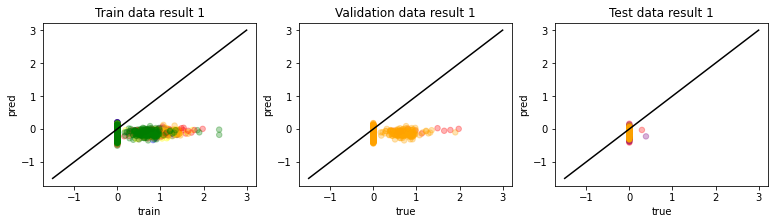

Epoch  100 Train_loss:  0.1202065  Validation_loss:  0.12788883  Test_loss:  0.072253555
Epoch  200 Train_loss:  0.11548092  Validation_loss:  0.12338994  Test_loss:  0.06388819
Epoch  300 Train_loss:  0.112465605  Validation_loss:  0.12055935  Test_loss:  0.058007557
Epoch  400 Train_loss:  0.11034576  Validation_loss:  0.11855748  Test_loss:  0.05369615
Epoch  500 Train_loss:  0.10876381  Validation_loss:  0.117051  Test_loss:  0.050367482
Epoch  600 Train_loss:  0.1075094  Validation_loss:  0.1158415  Test_loss:  0.047727913
Epoch  700 Train_loss:  0.106498145  Validation_loss:  0.11485458  Test_loss:  0.045579866
Epoch  800 Train_loss:  0.10566269  Validation_loss:  0.114028655  Test_loss:  0.043823414
Epoch  900 Train_loss:  0.10495243  Validation_loss:  0.113318846  Test_loss:  0.042366344
Epoch  1000 Train_loss:  0.10433594  Validation_loss:  0.112691306  Test_loss:  0.041157715


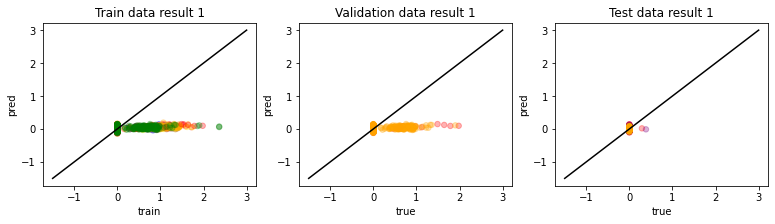

Epoch  1100 Train_loss:  0.10379209  Validation_loss:  0.11213348  Test_loss:  0.040128592
Epoch  1200 Train_loss:  0.10330519  Validation_loss:  0.11162555  Test_loss:  0.03928317
Epoch  1300 Train_loss:  0.10286455  Validation_loss:  0.11115795  Test_loss:  0.038573924
Epoch  1400 Train_loss:  0.10246172  Validation_loss:  0.11072541  Test_loss:  0.0379776
Epoch  1500 Train_loss:  0.10208849  Validation_loss:  0.11032186  Test_loss:  0.03743606
Epoch  1600 Train_loss:  0.1017397  Validation_loss:  0.10994162  Test_loss:  0.03699461
Epoch  1700 Train_loss:  0.10141122  Validation_loss:  0.109581105  Test_loss:  0.036630478
Epoch  1800 Train_loss:  0.10109947  Validation_loss:  0.10923563  Test_loss:  0.036316022
Epoch  1900 Train_loss:  0.100802034  Validation_loss:  0.10890307  Test_loss:  0.03603995
Epoch  2000 Train_loss:  0.100515746  Validation_loss:  0.10857979  Test_loss:  0.035817157


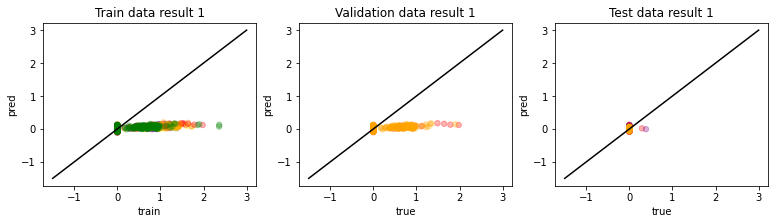

Epoch  2100 Train_loss:  0.10023932  Validation_loss:  0.10826765  Test_loss:  0.03561247
Epoch  2200 Train_loss:  0.09997184  Validation_loss:  0.10796345  Test_loss:  0.035447303
Epoch  2300 Train_loss:  0.09971111  Validation_loss:  0.10766681  Test_loss:  0.035305325
Epoch  2400 Train_loss:  0.09945624  Validation_loss:  0.107375346  Test_loss:  0.035176825
Epoch  2500 Train_loss:  0.09920664  Validation_loss:  0.10708846  Test_loss:  0.0350724
Epoch  2600 Train_loss:  0.098961614  Validation_loss:  0.10680665  Test_loss:  0.03498382
Epoch  2700 Train_loss:  0.09872092  Validation_loss:  0.10652846  Test_loss:  0.03491182
Epoch  2800 Train_loss:  0.09848335  Validation_loss:  0.10625339  Test_loss:  0.03486011
Epoch  2900 Train_loss:  0.09824902  Validation_loss:  0.105981834  Test_loss:  0.034804694
Epoch  3000 Train_loss:  0.09801682  Validation_loss:  0.10571143  Test_loss:  0.03477454


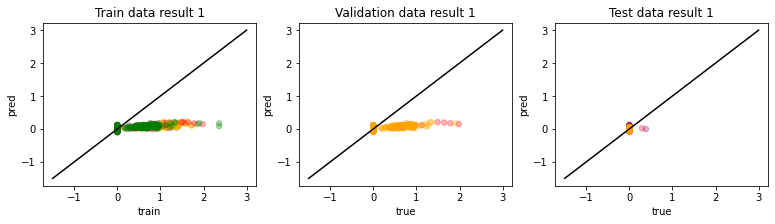

Epoch  3100 Train_loss:  0.09778668  Validation_loss:  0.105443485  Test_loss:  0.034745548
Epoch  3200 Train_loss:  0.09755838  Validation_loss:  0.10517721  Test_loss:  0.034719814
Epoch  3300 Train_loss:  0.09733156  Validation_loss:  0.10491246  Test_loss:  0.03471068
Epoch  3400 Train_loss:  0.097106025  Validation_loss:  0.1046481  Test_loss:  0.034716714
Epoch  3500 Train_loss:  0.09688081  Validation_loss:  0.10438321  Test_loss:  0.034730043
Epoch  3600 Train_loss:  0.09665657  Validation_loss:  0.10411932  Test_loss:  0.034736585
Epoch  3700 Train_loss:  0.09643275  Validation_loss:  0.10385558  Test_loss:  0.03475864
Epoch  3800 Train_loss:  0.096209  Validation_loss:  0.10359181  Test_loss:  0.034786187
Epoch  3900 Train_loss:  0.09598549  Validation_loss:  0.10332745  Test_loss:  0.034809668
Epoch  4000 Train_loss:  0.09576152  Validation_loss:  0.1030635  Test_loss:  0.03484169


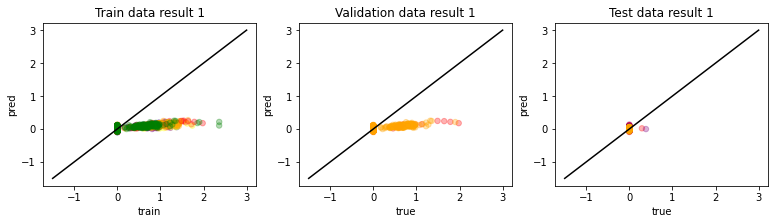

Epoch  4100 Train_loss:  0.095537595  Validation_loss:  0.10279836  Test_loss:  0.034892056
Epoch  4200 Train_loss:  0.0953132  Validation_loss:  0.10253293  Test_loss:  0.03494327
Epoch  4300 Train_loss:  0.09508852  Validation_loss:  0.10226607  Test_loss:  0.03499014
Epoch  4400 Train_loss:  0.0948625  Validation_loss:  0.101996966  Test_loss:  0.035052147
Epoch  4500 Train_loss:  0.09463561  Validation_loss:  0.101727605  Test_loss:  0.03511346
Epoch  4600 Train_loss:  0.09440792  Validation_loss:  0.101456255  Test_loss:  0.03518051
Epoch  4700 Train_loss:  0.09417899  Validation_loss:  0.10118403  Test_loss:  0.035249457
Epoch  4800 Train_loss:  0.09394885  Validation_loss:  0.10091106  Test_loss:  0.035311434
Epoch  4900 Train_loss:  0.09371712  Validation_loss:  0.10063424  Test_loss:  0.035401314
Epoch  5000 Train_loss:  0.093483865  Validation_loss:  0.1003567  Test_loss:  0.035482775


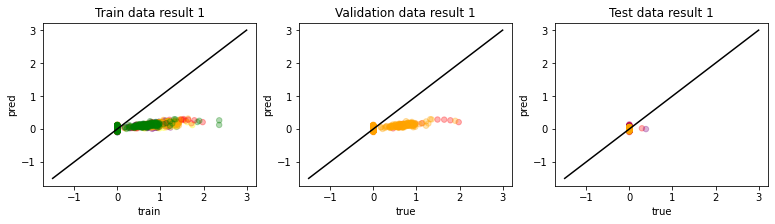

Epoch  5100 Train_loss:  0.09324931  Validation_loss:  0.10007716  Test_loss:  0.035577502
Epoch  5200 Train_loss:  0.093012944  Validation_loss:  0.09979556  Test_loss:  0.03565977
Epoch  5300 Train_loss:  0.09277498  Validation_loss:  0.09951197  Test_loss:  0.035749104
Epoch  5400 Train_loss:  0.09253539  Validation_loss:  0.09922602  Test_loss:  0.035849925
Epoch  5500 Train_loss:  0.09229349  Validation_loss:  0.098937735  Test_loss:  0.035941698
Epoch  5600 Train_loss:  0.09204933  Validation_loss:  0.09864642  Test_loss:  0.03605394
Epoch  5700 Train_loss:  0.09180348  Validation_loss:  0.098352104  Test_loss:  0.03616021
Epoch  5800 Train_loss:  0.09155585  Validation_loss:  0.098056026  Test_loss:  0.03627177
Epoch  5900 Train_loss:  0.09130603  Validation_loss:  0.09775755  Test_loss:  0.036380917
Epoch  6000 Train_loss:  0.09105388  Validation_loss:  0.09745564  Test_loss:  0.036499634


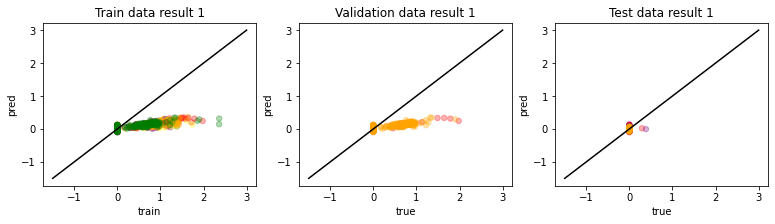

Epoch  6100 Train_loss:  0.09079933  Validation_loss:  0.09715087  Test_loss:  0.0366103
Epoch  6200 Train_loss:  0.090542674  Validation_loss:  0.09684335  Test_loss:  0.03673976
Epoch  6300 Train_loss:  0.09028348  Validation_loss:  0.0965336  Test_loss:  0.036852278
Epoch  6400 Train_loss:  0.09002203  Validation_loss:  0.09621995  Test_loss:  0.03698299
Epoch  6500 Train_loss:  0.08975841  Validation_loss:  0.09590432  Test_loss:  0.037104882
Epoch  6600 Train_loss:  0.08949227  Validation_loss:  0.09558526  Test_loss:  0.037233558
Epoch  6700 Train_loss:  0.08922379  Validation_loss:  0.09526251  Test_loss:  0.03736705
Epoch  6800 Train_loss:  0.08895215  Validation_loss:  0.094937176  Test_loss:  0.037496865
Epoch  6900 Train_loss:  0.08867792  Validation_loss:  0.094609134  Test_loss:  0.037646923
Epoch  7000 Train_loss:  0.08840187  Validation_loss:  0.09427779  Test_loss:  0.037781775


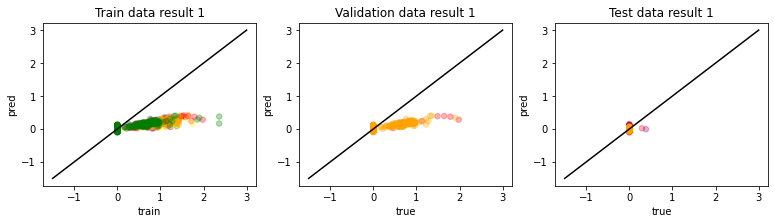

Epoch  7100 Train_loss:  0.08812309  Validation_loss:  0.093943074  Test_loss:  0.037913125
Epoch  7200 Train_loss:  0.08784181  Validation_loss:  0.093604796  Test_loss:  0.03805512
Epoch  7300 Train_loss:  0.08755731  Validation_loss:  0.09326347  Test_loss:  0.038202424
Epoch  7400 Train_loss:  0.08727088  Validation_loss:  0.09291997  Test_loss:  0.038343977
Epoch  7500 Train_loss:  0.08698156  Validation_loss:  0.09257224  Test_loss:  0.038488287
Epoch  7600 Train_loss:  0.086689495  Validation_loss:  0.09222156  Test_loss:  0.03864059
Epoch  7700 Train_loss:  0.086395234  Validation_loss:  0.09186821  Test_loss:  0.03878399
Epoch  7800 Train_loss:  0.08609853  Validation_loss:  0.0915121  Test_loss:  0.038950272
Epoch  7900 Train_loss:  0.08579889  Validation_loss:  0.09115355  Test_loss:  0.03910326
Epoch  8000 Train_loss:  0.085496694  Validation_loss:  0.09079164  Test_loss:  0.039253797


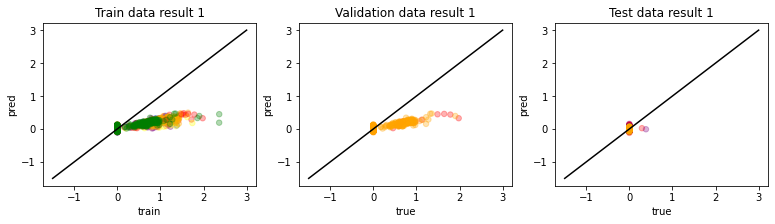

Epoch  8100 Train_loss:  0.085191995  Validation_loss:  0.090426095  Test_loss:  0.039408073
Epoch  8200 Train_loss:  0.084884785  Validation_loss:  0.09005682  Test_loss:  0.03956653
Epoch  8300 Train_loss:  0.08457528  Validation_loss:  0.08968522  Test_loss:  0.03972345
Epoch  8400 Train_loss:  0.08426272  Validation_loss:  0.08931014  Test_loss:  0.039886195
Epoch  8500 Train_loss:  0.08394811  Validation_loss:  0.08893226  Test_loss:  0.04004652
Epoch  8600 Train_loss:  0.083630435  Validation_loss:  0.08855112  Test_loss:  0.04021341
Epoch  8700 Train_loss:  0.083310425  Validation_loss:  0.088166945  Test_loss:  0.040375955
Epoch  8800 Train_loss:  0.08298859  Validation_loss:  0.08778049  Test_loss:  0.04053753
Epoch  8900 Train_loss:  0.082663886  Validation_loss:  0.087390296  Test_loss:  0.04071058
Epoch  9000 Train_loss:  0.08233656  Validation_loss:  0.08699906  Test_loss:  0.040881246


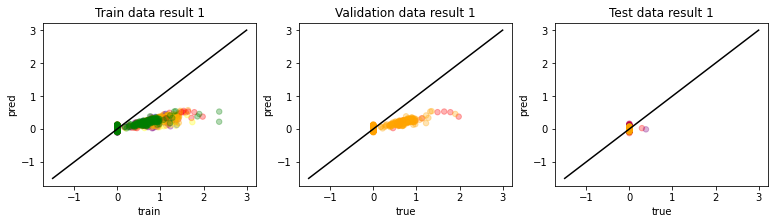

Epoch  9100 Train_loss:  0.08200834  Validation_loss:  0.086605184  Test_loss:  0.041045804
Epoch  9200 Train_loss:  0.08167691  Validation_loss:  0.08620805  Test_loss:  0.04121282
Epoch  9300 Train_loss:  0.08134387  Validation_loss:  0.08580801  Test_loss:  0.04137598
Epoch  9400 Train_loss:  0.08100795  Validation_loss:  0.08540613  Test_loss:  0.041542225
Epoch  9500 Train_loss:  0.080670595  Validation_loss:  0.085001074  Test_loss:  0.04170154
Epoch  9600 Train_loss:  0.08033013  Validation_loss:  0.08459355  Test_loss:  0.041878957
Epoch  9700 Train_loss:  0.07998818  Validation_loss:  0.084182635  Test_loss:  0.042056818
Epoch  9800 Train_loss:  0.079643905  Validation_loss:  0.08376925  Test_loss:  0.042223275
Epoch  9900 Train_loss:  0.079298586  Validation_loss:  0.08335456  Test_loss:  0.042391486
Epoch  10000 Train_loss:  0.0789503  Validation_loss:  0.08293808  Test_loss:  0.04256062


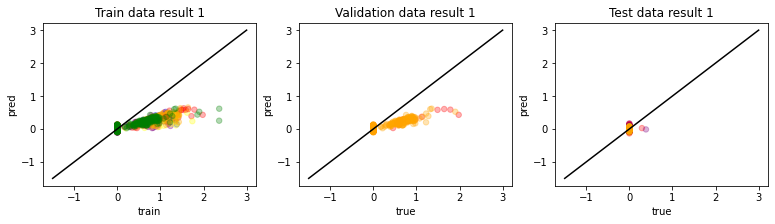

Epoch  10100 Train_loss:  0.07860098  Validation_loss:  0.08251977  Test_loss:  0.042727455
Epoch  10200 Train_loss:  0.07824935  Validation_loss:  0.08209916  Test_loss:  0.042902153
Epoch  10300 Train_loss:  0.07789673  Validation_loss:  0.08167597  Test_loss:  0.043064505
Epoch  10400 Train_loss:  0.07754145  Validation_loss:  0.08125075  Test_loss:  0.04323795
Epoch  10500 Train_loss:  0.07718496  Validation_loss:  0.080824256  Test_loss:  0.043405615
Epoch  10600 Train_loss:  0.07682744  Validation_loss:  0.080395885  Test_loss:  0.043571234
Epoch  10700 Train_loss:  0.07646827  Validation_loss:  0.07996672  Test_loss:  0.043742914
Epoch  10800 Train_loss:  0.07610779  Validation_loss:  0.07953424  Test_loss:  0.043895748
Epoch  10900 Train_loss:  0.07574493  Validation_loss:  0.079101  Test_loss:  0.044071667
Epoch  11000 Train_loss:  0.07538179  Validation_loss:  0.07866664  Test_loss:  0.044225387


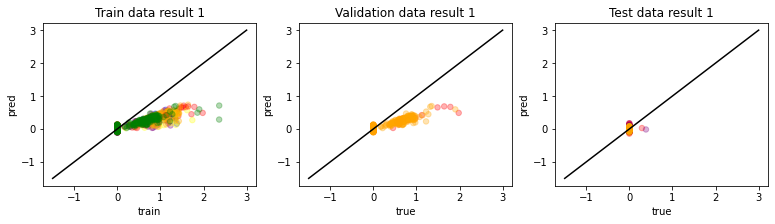

Epoch  11100 Train_loss:  0.07501749  Validation_loss:  0.07823071  Test_loss:  0.044391368
Epoch  11200 Train_loss:  0.07465121  Validation_loss:  0.0777939  Test_loss:  0.044554915
Epoch  11300 Train_loss:  0.07428376  Validation_loss:  0.0773549  Test_loss:  0.04472261
Epoch  11400 Train_loss:  0.073915444  Validation_loss:  0.076915294  Test_loss:  0.044882216
Epoch  11500 Train_loss:  0.07354571  Validation_loss:  0.07647527  Test_loss:  0.04505098
Epoch  11600 Train_loss:  0.073175244  Validation_loss:  0.07603364  Test_loss:  0.045217797
Epoch  11700 Train_loss:  0.07280537  Validation_loss:  0.07559267  Test_loss:  0.045373563
Epoch  11800 Train_loss:  0.07243423  Validation_loss:  0.07515024  Test_loss:  0.045525357
Epoch  11900 Train_loss:  0.07206189  Validation_loss:  0.074706554  Test_loss:  0.045684554
Epoch  12000 Train_loss:  0.07169036  Validation_loss:  0.074263826  Test_loss:  0.045837674


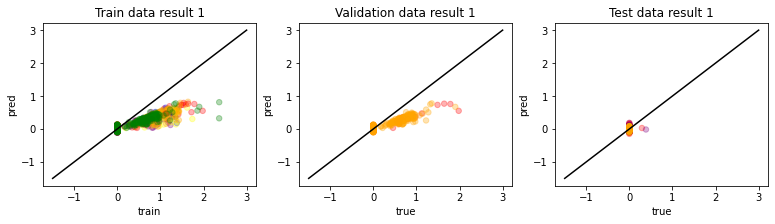

Epoch  12100 Train_loss:  0.071316905  Validation_loss:  0.07381953  Test_loss:  0.045994774
Epoch  12200 Train_loss:  0.07094294  Validation_loss:  0.07337535  Test_loss:  0.046141922
Epoch  12300 Train_loss:  0.07056859  Validation_loss:  0.072930336  Test_loss:  0.04629688
Epoch  12400 Train_loss:  0.070194244  Validation_loss:  0.07248546  Test_loss:  0.046443284
Epoch  12500 Train_loss:  0.0698197  Validation_loss:  0.07203918  Test_loss:  0.04660442
Epoch  12600 Train_loss:  0.069444425  Validation_loss:  0.07159449  Test_loss:  0.04675053
Epoch  12700 Train_loss:  0.06906918  Validation_loss:  0.071149744  Test_loss:  0.046900984
Epoch  12800 Train_loss:  0.06869345  Validation_loss:  0.07070383  Test_loss:  0.047051445
Epoch  12900 Train_loss:  0.068318784  Validation_loss:  0.070258096  Test_loss:  0.047192518
Epoch  13000 Train_loss:  0.067942575  Validation_loss:  0.06981235  Test_loss:  0.047340408


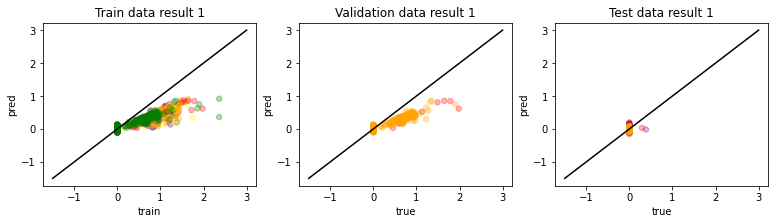

Epoch  13100 Train_loss:  0.06756745  Validation_loss:  0.069367856  Test_loss:  0.047489073
Epoch  13200 Train_loss:  0.06719343  Validation_loss:  0.06892332  Test_loss:  0.04763178
Epoch  13300 Train_loss:  0.06681878  Validation_loss:  0.068479314  Test_loss:  0.047768947
Epoch  13400 Train_loss:  0.06644463  Validation_loss:  0.06803615  Test_loss:  0.04790397
Epoch  13500 Train_loss:  0.06607124  Validation_loss:  0.06759337  Test_loss:  0.048042256
Epoch  13600 Train_loss:  0.06569901  Validation_loss:  0.0671522  Test_loss:  0.048177876
Epoch  13700 Train_loss:  0.065327205  Validation_loss:  0.06671193  Test_loss:  0.048308603
Epoch  13800 Train_loss:  0.06495586  Validation_loss:  0.066272244  Test_loss:  0.048437443
Epoch  13900 Train_loss:  0.06458468  Validation_loss:  0.06583516  Test_loss:  0.048567392
Epoch  14000 Train_loss:  0.06421519  Validation_loss:  0.065396935  Test_loss:  0.048702225


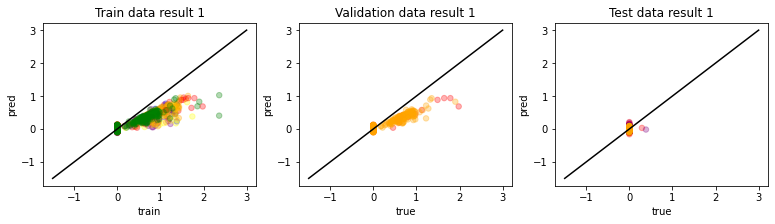

Epoch  14100 Train_loss:  0.063845314  Validation_loss:  0.06495896  Test_loss:  0.04882178
Epoch  14200 Train_loss:  0.06347755  Validation_loss:  0.064524405  Test_loss:  0.048937935
Epoch  14300 Train_loss:  0.063108854  Validation_loss:  0.064089894  Test_loss:  0.049069524
Epoch  14400 Train_loss:  0.062742494  Validation_loss:  0.06365661  Test_loss:  0.049189396
Epoch  14500 Train_loss:  0.06237743  Validation_loss:  0.06322523  Test_loss:  0.0493101
Epoch  14600 Train_loss:  0.06201299  Validation_loss:  0.06279523  Test_loss:  0.049422983
Epoch  14700 Train_loss:  0.061649993  Validation_loss:  0.06236695  Test_loss:  0.0495378
Epoch  14800 Train_loss:  0.06128696  Validation_loss:  0.061939742  Test_loss:  0.049653422
Epoch  14900 Train_loss:  0.06092668  Validation_loss:  0.061516277  Test_loss:  0.049762506
Epoch  15000 Train_loss:  0.060567822  Validation_loss:  0.061094023  Test_loss:  0.049863964


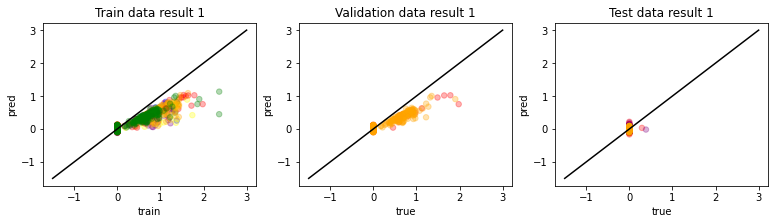

Epoch  15100 Train_loss:  0.06020961  Validation_loss:  0.060672604  Test_loss:  0.04997202
Epoch  15200 Train_loss:  0.059852514  Validation_loss:  0.0602535  Test_loss:  0.050075136
Epoch  15300 Train_loss:  0.05949721  Validation_loss:  0.059834782  Test_loss:  0.050176814
Epoch  15400 Train_loss:  0.05914365  Validation_loss:  0.059418276  Test_loss:  0.05028018
Epoch  15500 Train_loss:  0.058790985  Validation_loss:  0.059004024  Test_loss:  0.050384086
Epoch  15600 Train_loss:  0.058441244  Validation_loss:  0.05859338  Test_loss:  0.050478183
Epoch  15700 Train_loss:  0.058092657  Validation_loss:  0.058185525  Test_loss:  0.0505622
Epoch  15800 Train_loss:  0.057744674  Validation_loss:  0.057777364  Test_loss:  0.050662432
Epoch  15900 Train_loss:  0.05739952  Validation_loss:  0.05737233  Test_loss:  0.050749954
Epoch  16000 Train_loss:  0.05705457  Validation_loss:  0.05696919  Test_loss:  0.050844878


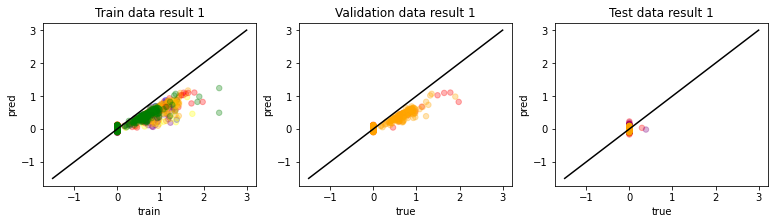

Epoch  16100 Train_loss:  0.056713704  Validation_loss:  0.05656923  Test_loss:  0.050923582
Epoch  16200 Train_loss:  0.056373917  Validation_loss:  0.056171972  Test_loss:  0.05100301
Epoch  16300 Train_loss:  0.05603437  Validation_loss:  0.05577383  Test_loss:  0.05109114
Epoch  16400 Train_loss:  0.05569593  Validation_loss:  0.055381294  Test_loss:  0.05117841
Epoch  16500 Train_loss:  0.055360723  Validation_loss:  0.05498975  Test_loss:  0.051258586
Epoch  16600 Train_loss:  0.055029184  Validation_loss:  0.054600667  Test_loss:  0.051327206
Epoch  16700 Train_loss:  0.054696646  Validation_loss:  0.05421311  Test_loss:  0.051412217
Epoch  16800 Train_loss:  0.054367546  Validation_loss:  0.05382849  Test_loss:  0.051485244
Epoch  16900 Train_loss:  0.05404203  Validation_loss:  0.053447306  Test_loss:  0.05155395
Epoch  17000 Train_loss:  0.053715605  Validation_loss:  0.053067744  Test_loss:  0.051629715


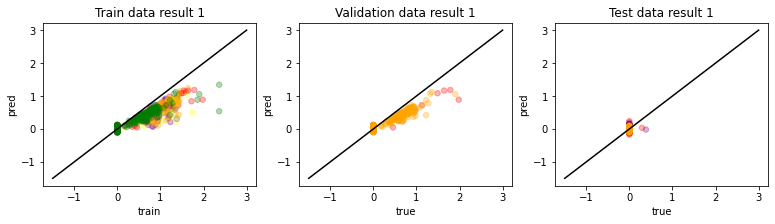

Epoch  17100 Train_loss:  0.053393126  Validation_loss:  0.052692153  Test_loss:  0.051697947
Epoch  17200 Train_loss:  0.053072054  Validation_loss:  0.05231776  Test_loss:  0.05176036
Epoch  17300 Train_loss:  0.052753694  Validation_loss:  0.051947366  Test_loss:  0.051822092
Epoch  17400 Train_loss:  0.05243582  Validation_loss:  0.05157884  Test_loss:  0.05188805
Epoch  17500 Train_loss:  0.052120686  Validation_loss:  0.05121149  Test_loss:  0.05195027
Epoch  17600 Train_loss:  0.051807817  Validation_loss:  0.050847862  Test_loss:  0.052010115
Epoch  17700 Train_loss:  0.051497053  Validation_loss:  0.05048562  Test_loss:  0.05206997
Epoch  17800 Train_loss:  0.051189464  Validation_loss:  0.050127856  Test_loss:  0.052125104
Epoch  17900 Train_loss:  0.050883427  Validation_loss:  0.049772855  Test_loss:  0.05217903
Epoch  18000 Train_loss:  0.05057863  Validation_loss:  0.04942006  Test_loss:  0.05223024


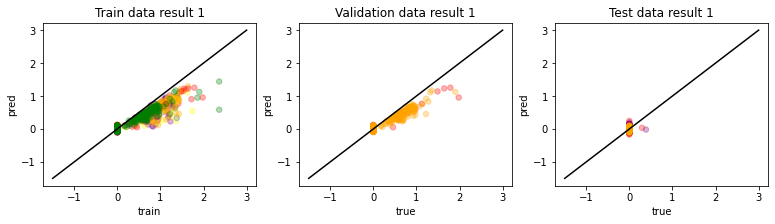

Epoch  18100 Train_loss:  0.050275486  Validation_loss:  0.049068607  Test_loss:  0.052289356
Epoch  18200 Train_loss:  0.049978003  Validation_loss:  0.04872364  Test_loss:  0.05233132
Epoch  18300 Train_loss:  0.0496786  Validation_loss:  0.04837772  Test_loss:  0.052382424
Epoch  18400 Train_loss:  0.04938152  Validation_loss:  0.048034  Test_loss:  0.052432872
Epoch  18500 Train_loss:  0.049088478  Validation_loss:  0.04769503  Test_loss:  0.052480288
Epoch  18600 Train_loss:  0.04879652  Validation_loss:  0.047357045  Test_loss:  0.05253241
Epoch  18700 Train_loss:  0.0485083  Validation_loss:  0.04702465  Test_loss:  0.052563407
Epoch  18800 Train_loss:  0.048220366  Validation_loss:  0.046691302  Test_loss:  0.052616466
Epoch  18900 Train_loss:  0.047934357  Validation_loss:  0.04636077  Test_loss:  0.052657247
Epoch  19000 Train_loss:  0.047653347  Validation_loss:  0.046036992  Test_loss:  0.05268701


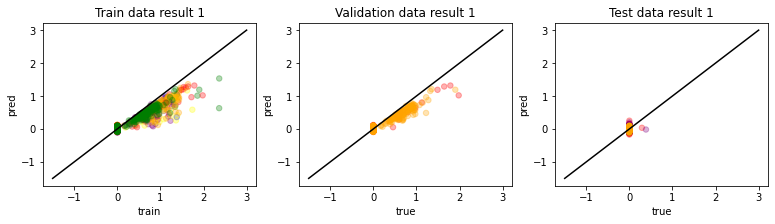

Epoch  19100 Train_loss:  0.047370873  Validation_loss:  0.045712546  Test_loss:  0.052731756
Epoch  19200 Train_loss:  0.04709271  Validation_loss:  0.045390498  Test_loss:  0.052764416
Epoch  19300 Train_loss:  0.04681769  Validation_loss:  0.04507272  Test_loss:  0.052792132
Epoch  19400 Train_loss:  0.046541106  Validation_loss:  0.04475456  Test_loss:  0.052834302
Epoch  19500 Train_loss:  0.046269853  Validation_loss:  0.044442255  Test_loss:  0.052858677
Epoch  19600 Train_loss:  0.045998212  Validation_loss:  0.044130873  Test_loss:  0.05290059
Epoch  19700 Train_loss:  0.045730628  Validation_loss:  0.043820728  Test_loss:  0.05292476
Epoch  19800 Train_loss:  0.045465387  Validation_loss:  0.04351677  Test_loss:  0.05294926
Epoch  19900 Train_loss:  0.045202345  Validation_loss:  0.043213513  Test_loss:  0.052976068
Epoch  20000 Train_loss:  0.044940848  Validation_loss:  0.042913705  Test_loss:  0.052998558


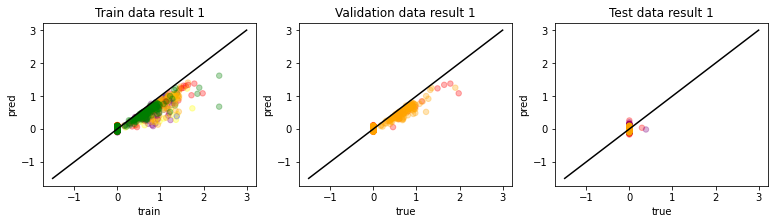

In [42]:
num_epochs = 20001
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.04493849  Validation_loss:  0.042911254  Test_loss:  0.05299712


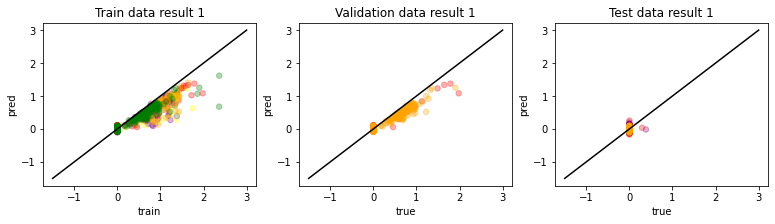

Epoch  100 Train_loss:  0.042634446  Validation_loss:  0.04028251  Test_loss:  0.053136464
Epoch  200 Train_loss:  0.040307708  Validation_loss:  0.037638832  Test_loss:  0.05326524
Epoch  300 Train_loss:  0.038188074  Validation_loss:  0.03524025  Test_loss:  0.05327727
Epoch  400 Train_loss:  0.03624175  Validation_loss:  0.03307154  Test_loss:  0.053188495
Epoch  500 Train_loss:  0.03445009  Validation_loss:  0.031081358  Test_loss:  0.053087022
Epoch  600 Train_loss:  0.03281275  Validation_loss:  0.029275734  Test_loss:  0.052892406
Epoch  700 Train_loss:  0.03130754  Validation_loss:  0.027639449  Test_loss:  0.052691545
Epoch  800 Train_loss:  0.029922385  Validation_loss:  0.026146462  Test_loss:  0.052437156
Epoch  900 Train_loss:  0.02865064  Validation_loss:  0.024800707  Test_loss:  0.052139454
Epoch  1000 Train_loss:  0.027469652  Validation_loss:  0.023563566  Test_loss:  0.0518358


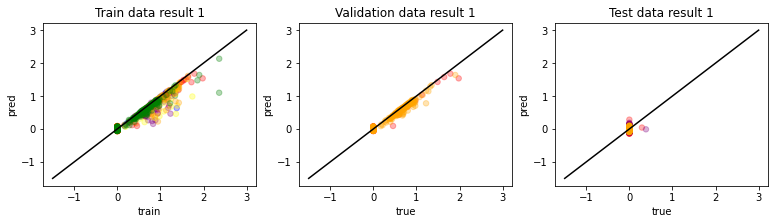

Epoch  1100 Train_loss:  0.0263692  Validation_loss:  0.02242428  Test_loss:  0.05156062
Epoch  1200 Train_loss:  0.025348134  Validation_loss:  0.02137929  Test_loss:  0.051248964
Epoch  1300 Train_loss:  0.024396088  Validation_loss:  0.020421326  Test_loss:  0.0509329
Epoch  1400 Train_loss:  0.023511173  Validation_loss:  0.019563172  Test_loss:  0.05063568
Epoch  1500 Train_loss:  0.022690477  Validation_loss:  0.01878134  Test_loss:  0.05028003
Epoch  1600 Train_loss:  0.021904005  Validation_loss:  0.018030318  Test_loss:  0.049991556
Epoch  1700 Train_loss:  0.021167748  Validation_loss:  0.017340077  Test_loss:  0.049708825
Epoch  1800 Train_loss:  0.020476306  Validation_loss:  0.016703947  Test_loss:  0.049400214
Epoch  1900 Train_loss:  0.019823307  Validation_loss:  0.016114606  Test_loss:  0.049111847
Epoch  2000 Train_loss:  0.01920355  Validation_loss:  0.015559396  Test_loss:  0.04882094


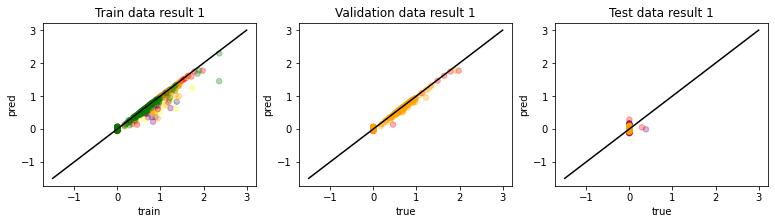

Epoch  2100 Train_loss:  0.01860584  Validation_loss:  0.015021791  Test_loss:  0.048577636
Epoch  2200 Train_loss:  0.018064406  Validation_loss:  0.014566412  Test_loss:  0.04825521
Epoch  2300 Train_loss:  0.017549722  Validation_loss:  0.0141343605  Test_loss:  0.047989756
Epoch  2400 Train_loss:  0.017033353  Validation_loss:  0.013692041  Test_loss:  0.04775075
Epoch  2500 Train_loss:  0.0165798  Validation_loss:  0.01333535  Test_loss:  0.047449328
Epoch  2600 Train_loss:  0.016112896  Validation_loss:  0.012944392  Test_loss:  0.047205914
Epoch  2700 Train_loss:  0.015670994  Validation_loss:  0.012582769  Test_loss:  0.046980616
Epoch  2800 Train_loss:  0.015253087  Validation_loss:  0.012246197  Test_loss:  0.04675181
Epoch  2900 Train_loss:  0.014865751  Validation_loss:  0.011954902  Test_loss:  0.046500873
Epoch  3000 Train_loss:  0.014504351  Validation_loss:  0.011691111  Test_loss:  0.04625762


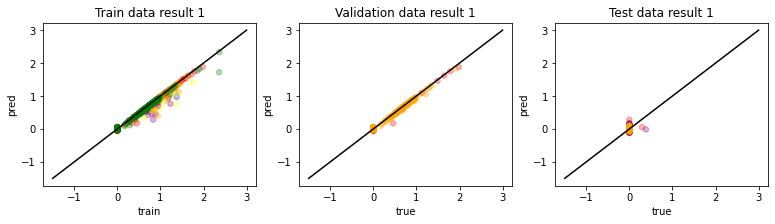

Epoch  3100 Train_loss:  0.01413684  Validation_loss:  0.011396368  Test_loss:  0.046023153
Epoch  3200 Train_loss:  0.01379721  Validation_loss:  0.011147397  Test_loss:  0.045773186
Epoch  3300 Train_loss:  0.013454202  Validation_loss:  0.010877421  Test_loss:  0.04557178
Epoch  3400 Train_loss:  0.013159984  Validation_loss:  0.010683835  Test_loss:  0.045305207
Epoch  3500 Train_loss:  0.012840192  Validation_loss:  0.010436376  Test_loss:  0.045135077
Epoch  3600 Train_loss:  0.012538999  Validation_loss:  0.010217753  Test_loss:  0.044932246
Epoch  3700 Train_loss:  0.012269017  Validation_loss:  0.010032381  Test_loss:  0.04472157
Epoch  3800 Train_loss:  0.01201366  Validation_loss:  0.00987196  Test_loss:  0.044466894
Epoch  3900 Train_loss:  0.0117548965  Validation_loss:  0.009682759  Test_loss:  0.04426799
Epoch  4000 Train_loss:  0.011477779  Validation_loss:  0.009457926  Test_loss:  0.044143457


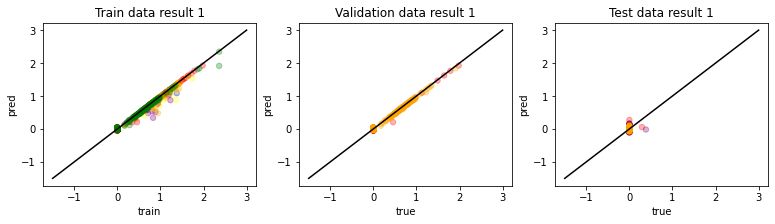

Epoch  4100 Train_loss:  0.011229174  Validation_loss:  0.009274144  Test_loss:  0.043947037
Epoch  4200 Train_loss:  0.011029917  Validation_loss:  0.009169121  Test_loss:  0.04369444
Epoch  4300 Train_loss:  0.010781071  Validation_loss:  0.008965012  Test_loss:  0.043537546
Epoch  4400 Train_loss:  0.010572936  Validation_loss:  0.008828604  Test_loss:  0.04334236
Epoch  4500 Train_loss:  0.010370298  Validation_loss:  0.008695833  Test_loss:  0.043178003
Epoch  4600 Train_loss:  0.0101613505  Validation_loss:  0.008535526  Test_loss:  0.04300005
Epoch  4700 Train_loss:  0.01001008  Validation_loss:  0.008474199  Test_loss:  0.042769495
Epoch  4800 Train_loss:  0.009799802  Validation_loss:  0.008298579  Test_loss:  0.04264664
Epoch  4900 Train_loss:  0.009610681  Validation_loss:  0.008173137  Test_loss:  0.04247289
Epoch  5000 Train_loss:  0.009440099  Validation_loss:  0.008055444  Test_loss:  0.042303152


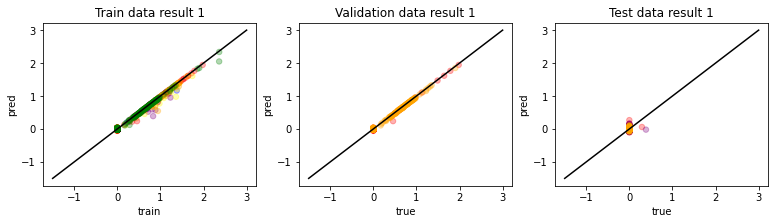

Epoch  5100 Train_loss:  0.009263967  Validation_loss:  0.007925459  Test_loss:  0.04217002
Epoch  5200 Train_loss:  0.009137016  Validation_loss:  0.007872751  Test_loss:  0.04197582
Epoch  5300 Train_loss:  0.009004254  Validation_loss:  0.007792255  Test_loss:  0.041783176
Epoch  5400 Train_loss:  0.008798129  Validation_loss:  0.007603254  Test_loss:  0.041708644
Epoch  5500 Train_loss:  0.0086631235  Validation_loss:  0.00751714  Test_loss:  0.041529085
Epoch  5600 Train_loss:  0.008537728  Validation_loss:  0.0074401917  Test_loss:  0.041380778
Epoch  5700 Train_loss:  0.0084034605  Validation_loss:  0.0073422026  Test_loss:  0.041231807
Epoch  5800 Train_loss:  0.008258277  Validation_loss:  0.007236371  Test_loss:  0.041096367
Epoch  5900 Train_loss:  0.008102246  Validation_loss:  0.0070994124  Test_loss:  0.041003067
Epoch  6000 Train_loss:  0.008011941  Validation_loss:  0.0070655607  Test_loss:  0.04082605


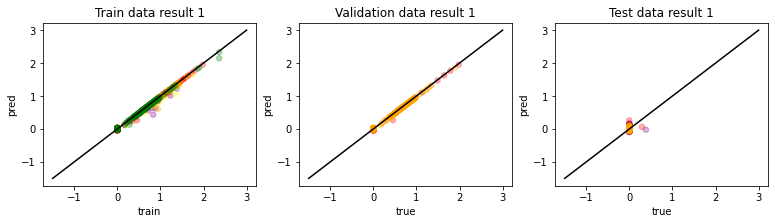

Epoch  6100 Train_loss:  0.007895344  Validation_loss:  0.0069778864  Test_loss:  0.040681645
Epoch  6200 Train_loss:  0.00774053  Validation_loss:  0.0068417974  Test_loss:  0.04059232
Epoch  6300 Train_loss:  0.007632439  Validation_loss:  0.006760695  Test_loss:  0.040446006
Epoch  6400 Train_loss:  0.007534984  Validation_loss:  0.0067209466  Test_loss:  0.040301498
Epoch  6500 Train_loss:  0.0074312226  Validation_loss:  0.0066507473  Test_loss:  0.040203605
Epoch  6600 Train_loss:  0.0072951177  Validation_loss:  0.006527423  Test_loss:  0.040109854
Epoch  6700 Train_loss:  0.0072092707  Validation_loss:  0.0064766617  Test_loss:  0.03996904
Epoch  6800 Train_loss:  0.007151746  Validation_loss:  0.006463241  Test_loss:  0.03979896
Epoch  6900 Train_loss:  0.007037286  Validation_loss:  0.0063644126  Test_loss:  0.039707176
Epoch  7000 Train_loss:  0.0069311545  Validation_loss:  0.006277146  Test_loss:  0.039613936


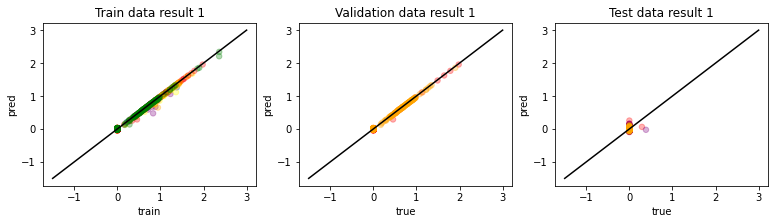

Epoch  7100 Train_loss:  0.0068634567  Validation_loss:  0.0062545636  Test_loss:  0.03947002
Epoch  7200 Train_loss:  0.0067991437  Validation_loss:  0.00623344  Test_loss:  0.03934989
Epoch  7300 Train_loss:  0.006711627  Validation_loss:  0.006151317  Test_loss:  0.039244935
Epoch  7400 Train_loss:  0.006572495  Validation_loss:  0.0060139974  Test_loss:  0.039179184
Epoch  7500 Train_loss:  0.0065362155  Validation_loss:  0.0060072346  Test_loss:  0.039046586
Epoch  7600 Train_loss:  0.0064395545  Validation_loss:  0.0059261587  Test_loss:  0.03894757
Epoch  7700 Train_loss:  0.006375234  Validation_loss:  0.005887458  Test_loss:  0.038820885
Epoch  7800 Train_loss:  0.0062808413  Validation_loss:  0.005801708  Test_loss:  0.038752418
Epoch  7900 Train_loss:  0.00621343  Validation_loss:  0.0057553607  Test_loss:  0.03863969
Epoch  8000 Train_loss:  0.0061554974  Validation_loss:  0.0057297186  Test_loss:  0.038531005


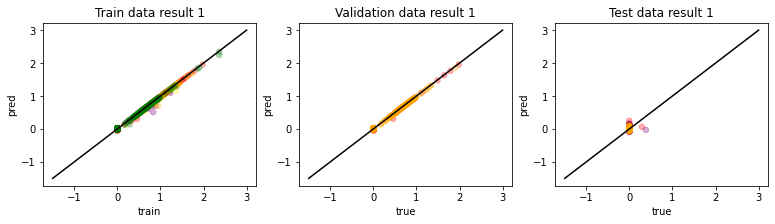

Epoch  8100 Train_loss:  0.0060657724  Validation_loss:  0.0056438535  Test_loss:  0.038455226
Epoch  8200 Train_loss:  0.005998704  Validation_loss:  0.0055910754  Test_loss:  0.038367666
Epoch  8300 Train_loss:  0.00590768  Validation_loss:  0.005512559  Test_loss:  0.03828018
Epoch  8400 Train_loss:  0.005893609  Validation_loss:  0.0055260514  Test_loss:  0.038158137
Epoch  8500 Train_loss:  0.0058050477  Validation_loss:  0.0054511335  Test_loss:  0.038075466
Epoch  8600 Train_loss:  0.0057750167  Validation_loss:  0.0054363497  Test_loss:  0.037956443
Epoch  8700 Train_loss:  0.005732718  Validation_loss:  0.005424235  Test_loss:  0.037859082
Epoch  8800 Train_loss:  0.0056317053  Validation_loss:  0.005312931  Test_loss:  0.03781908
Epoch  8900 Train_loss:  0.0055941115  Validation_loss:  0.005287495  Test_loss:  0.03769938
Epoch  9000 Train_loss:  0.005508377  Validation_loss:  0.0052173357  Test_loss:  0.03764846


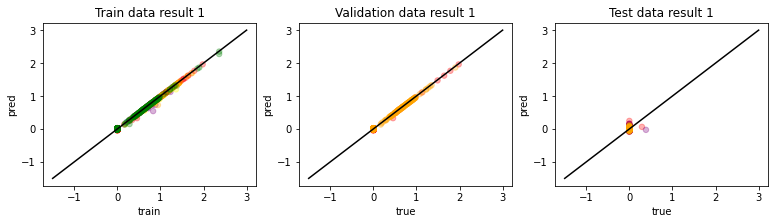

Epoch  9100 Train_loss:  0.0054573338  Validation_loss:  0.005179939  Test_loss:  0.037563983
Epoch  9200 Train_loss:  0.005409856  Validation_loss:  0.0051356307  Test_loss:  0.03749118
Epoch  9300 Train_loss:  0.005346275  Validation_loss:  0.0050800494  Test_loss:  0.037406348
Epoch  9400 Train_loss:  0.005315603  Validation_loss:  0.0050827125  Test_loss:  0.03731107
Epoch  9500 Train_loss:  0.0053054374  Validation_loss:  0.0051010503  Test_loss:  0.03718967
Epoch  9600 Train_loss:  0.0052331365  Validation_loss:  0.0050322358  Test_loss:  0.03711564
Epoch  9700 Train_loss:  0.0051584197  Validation_loss:  0.004962432  Test_loss:  0.037062448
Epoch  9800 Train_loss:  0.005132278  Validation_loss:  0.0049640522  Test_loss:  0.036971524
Epoch  9900 Train_loss:  0.005119369  Validation_loss:  0.004972013  Test_loss:  0.036863487
Epoch  10000 Train_loss:  0.0050483383  Validation_loss:  0.0048960126  Test_loss:  0.036808714


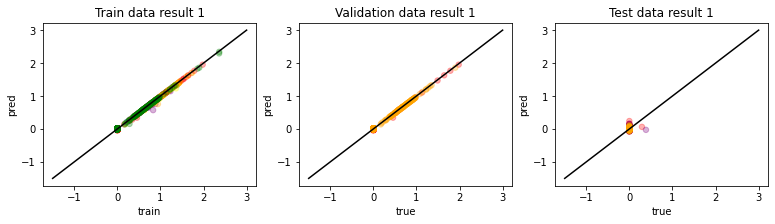

Epoch  10100 Train_loss:  0.004984744  Validation_loss:  0.004826803  Test_loss:  0.03675105
Epoch  10200 Train_loss:  0.0049531437  Validation_loss:  0.0048010247  Test_loss:  0.036666494
Epoch  10300 Train_loss:  0.0049373647  Validation_loss:  0.004814109  Test_loss:  0.036556084
Epoch  10400 Train_loss:  0.0048748385  Validation_loss:  0.0047562383  Test_loss:  0.036516953
Epoch  10500 Train_loss:  0.0048006177  Validation_loss:  0.0046803765  Test_loss:  0.036476396
Epoch  10600 Train_loss:  0.004779446  Validation_loss:  0.004670082  Test_loss:  0.036389746
Epoch  10700 Train_loss:  0.004735837  Validation_loss:  0.0046306234  Test_loss:  0.036333065
Epoch  10800 Train_loss:  0.0046992404  Validation_loss:  0.004604968  Test_loss:  0.036242474
Epoch  10900 Train_loss:  0.0046826964  Validation_loss:  0.00459521  Test_loss:  0.03614974
Epoch  11000 Train_loss:  0.004591381  Validation_loss:  0.00448983  Test_loss:  0.03612851


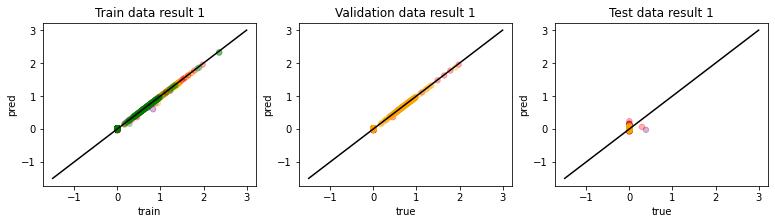

Epoch  11100 Train_loss:  0.0046035536  Validation_loss:  0.0045244796  Test_loss:  0.036000952
Epoch  11200 Train_loss:  0.004569457  Validation_loss:  0.004498261  Test_loss:  0.035948157
Epoch  11300 Train_loss:  0.0045744646  Validation_loss:  0.0045143175  Test_loss:  0.03584981
Epoch  11400 Train_loss:  0.00451757  Validation_loss:  0.0044510136  Test_loss:  0.03580949
Epoch  11500 Train_loss:  0.0044854265  Validation_loss:  0.004436972  Test_loss:  0.035738286
Epoch  11600 Train_loss:  0.004452969  Validation_loss:  0.0044126017  Test_loss:  0.035687
Epoch  11700 Train_loss:  0.004385487  Validation_loss:  0.004335804  Test_loss:  0.03564532
Epoch  11800 Train_loss:  0.004396785  Validation_loss:  0.0043571447  Test_loss:  0.035540935
Epoch  11900 Train_loss:  0.004336808  Validation_loss:  0.004284592  Test_loss:  0.035525702
Epoch  12000 Train_loss:  0.0042376625  Validation_loss:  0.0041827285  Test_loss:  0.03550584


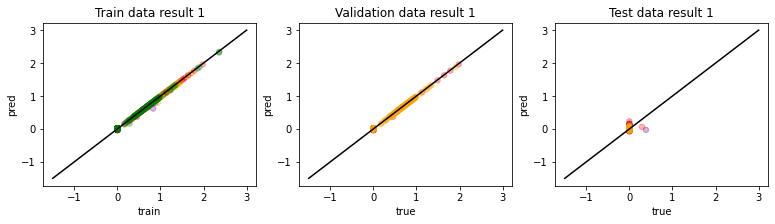

Epoch  12100 Train_loss:  0.0042845784  Validation_loss:  0.0042559993  Test_loss:  0.035388038
Epoch  12200 Train_loss:  0.004247436  Validation_loss:  0.0042036395  Test_loss:  0.035332453
Epoch  12300 Train_loss:  0.004208966  Validation_loss:  0.0041625286  Test_loss:  0.035281923
Epoch  12400 Train_loss:  0.0041551534  Validation_loss:  0.004100063  Test_loss:  0.035243694
Epoch  12500 Train_loss:  0.0041468786  Validation_loss:  0.004118166  Test_loss:  0.035151996
Epoch  12600 Train_loss:  0.0040708333  Validation_loss:  0.004020318  Test_loss:  0.03515571
Epoch  12700 Train_loss:  0.0041387626  Validation_loss:  0.0041419216  Test_loss:  0.03500635
Epoch  12800 Train_loss:  0.004065668  Validation_loss:  0.0040540188  Test_loss:  0.03496761
Epoch  12900 Train_loss:  0.0041017365  Validation_loss:  0.0041277013  Test_loss:  0.034870286
Epoch  13000 Train_loss:  0.004019031  Validation_loss:  0.004023937  Test_loss:  0.034870215


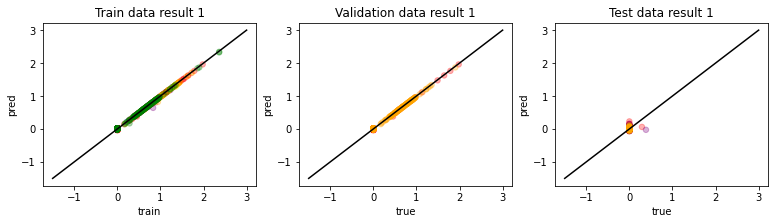

Epoch  13100 Train_loss:  0.003959485  Validation_loss:  0.003947617  Test_loss:  0.03485513
Epoch  13200 Train_loss:  0.003965611  Validation_loss:  0.003972591  Test_loss:  0.03477077
Epoch  13300 Train_loss:  0.0039804303  Validation_loss:  0.003992747  Test_loss:  0.034674436
Epoch  13400 Train_loss:  0.003916437  Validation_loss:  0.0039262497  Test_loss:  0.034664765
Epoch  13500 Train_loss:  0.0039214827  Validation_loss:  0.0039382563  Test_loss:  0.03458456
Epoch  13600 Train_loss:  0.003886915  Validation_loss:  0.0039190203  Test_loss:  0.034535367
Epoch  13700 Train_loss:  0.0038558184  Validation_loss:  0.0039000607  Test_loss:  0.034493998
Epoch  13800 Train_loss:  0.0038412968  Validation_loss:  0.0038967829  Test_loss:  0.034420565
Epoch  13900 Train_loss:  0.0038060949  Validation_loss:  0.003851732  Test_loss:  0.034386937
Epoch  14000 Train_loss:  0.0038221325  Validation_loss:  0.0038806824  Test_loss:  0.034310065


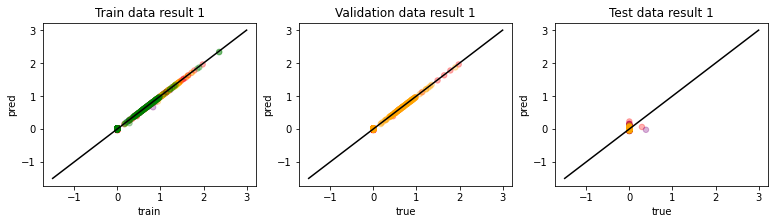

Epoch  14100 Train_loss:  0.003774118  Validation_loss:  0.0038258496  Test_loss:  0.03426245
Epoch  14200 Train_loss:  0.0037852004  Validation_loss:  0.0038445315  Test_loss:  0.03422002
Epoch  14300 Train_loss:  0.0037543555  Validation_loss:  0.003824366  Test_loss:  0.03417053
Epoch  14400 Train_loss:  0.00371086  Validation_loss:  0.0037709698  Test_loss:  0.0341411
Epoch  14500 Train_loss:  0.003693869  Validation_loss:  0.0037527257  Test_loss:  0.034112263
Epoch  14600 Train_loss:  0.0036770205  Validation_loss:  0.003740368  Test_loss:  0.034022816
Epoch  14700 Train_loss:  0.003657985  Validation_loss:  0.0037169417  Test_loss:  0.033984307
Epoch  14800 Train_loss:  0.003636108  Validation_loss:  0.0037000717  Test_loss:  0.033931985
Epoch  14900 Train_loss:  0.0036313655  Validation_loss:  0.003701735  Test_loss:  0.03388334
Epoch  15000 Train_loss:  0.0035628078  Validation_loss:  0.003614793  Test_loss:  0.033869676


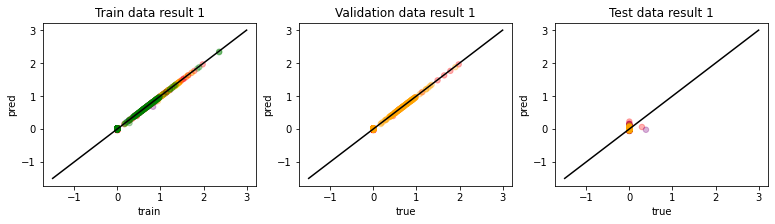

Epoch  15100 Train_loss:  0.0035601603  Validation_loss:  0.0035960146  Test_loss:  0.033838414
Epoch  15200 Train_loss:  0.003551809  Validation_loss:  0.0036022177  Test_loss:  0.03376309
Epoch  15300 Train_loss:  0.003532177  Validation_loss:  0.0035710465  Test_loss:  0.033707567
Epoch  15400 Train_loss:  0.0034944057  Validation_loss:  0.0035303503  Test_loss:  0.033691697
Epoch  15500 Train_loss:  0.0035017007  Validation_loss:  0.0035574865  Test_loss:  0.033622395
Epoch  15600 Train_loss:  0.0035358334  Validation_loss:  0.0036085155  Test_loss:  0.03357317
Epoch  15700 Train_loss:  0.003510546  Validation_loss:  0.0035786186  Test_loss:  0.033510745
Epoch  15800 Train_loss:  0.0035483309  Validation_loss:  0.0036390608  Test_loss:  0.033409916
Epoch  15900 Train_loss:  0.0034475785  Validation_loss:  0.0035053566  Test_loss:  0.0334429
Epoch  16000 Train_loss:  0.0034394714  Validation_loss:  0.0035044116  Test_loss:  0.03340925


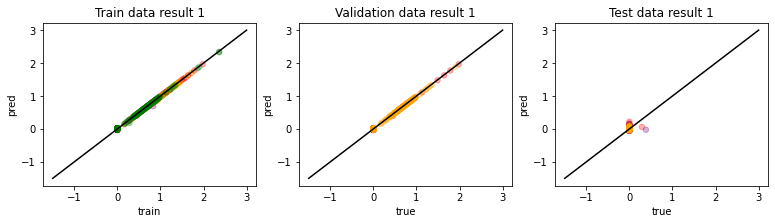

Epoch  16100 Train_loss:  0.003398156  Validation_loss:  0.003450038  Test_loss:  0.033386473
Epoch  16200 Train_loss:  0.0033933118  Validation_loss:  0.0034599698  Test_loss:  0.03332517
Epoch  16300 Train_loss:  0.0033604712  Validation_loss:  0.003428991  Test_loss:  0.033295833
Epoch  16400 Train_loss:  0.0033162052  Validation_loss:  0.0033780637  Test_loss:  0.033286612
Epoch  16500 Train_loss:  0.0033370324  Validation_loss:  0.0034090336  Test_loss:  0.033202626
Epoch  16600 Train_loss:  0.0033605937  Validation_loss:  0.0034490686  Test_loss:  0.033164404
Epoch  16700 Train_loss:  0.0032504888  Validation_loss:  0.0033069504  Test_loss:  0.033181287
Epoch  16800 Train_loss:  0.003266752  Validation_loss:  0.0033415372  Test_loss:  0.03312453
Epoch  16900 Train_loss:  0.0032590765  Validation_loss:  0.0033430576  Test_loss:  0.03308473
Epoch  17000 Train_loss:  0.0032606453  Validation_loss:  0.00334561  Test_loss:  0.033018377


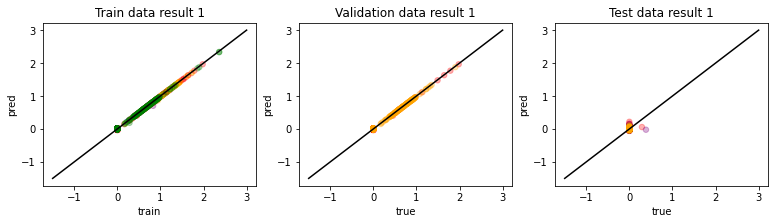

Epoch  17100 Train_loss:  0.0032687855  Validation_loss:  0.003355882  Test_loss:  0.032982748
Epoch  17200 Train_loss:  0.0032423257  Validation_loss:  0.00331624  Test_loss:  0.032951374
Epoch  17300 Train_loss:  0.003256151  Validation_loss:  0.0033481352  Test_loss:  0.03288897
Epoch  17400 Train_loss:  0.003211714  Validation_loss:  0.0032967639  Test_loss:  0.032881897
Epoch  17500 Train_loss:  0.0031654253  Validation_loss:  0.0032321059  Test_loss:  0.032856513
Epoch  17600 Train_loss:  0.003174936  Validation_loss:  0.003235501  Test_loss:  0.03281274
Epoch  17700 Train_loss:  0.0031600734  Validation_loss:  0.0032276013  Test_loss:  0.032761835
Epoch  17800 Train_loss:  0.0031561549  Validation_loss:  0.0032214562  Test_loss:  0.03272973
Epoch  17900 Train_loss:  0.0031956458  Validation_loss:  0.0032804979  Test_loss:  0.032664955
Epoch  18000 Train_loss:  0.0031061273  Validation_loss:  0.0031799222  Test_loss:  0.032688495


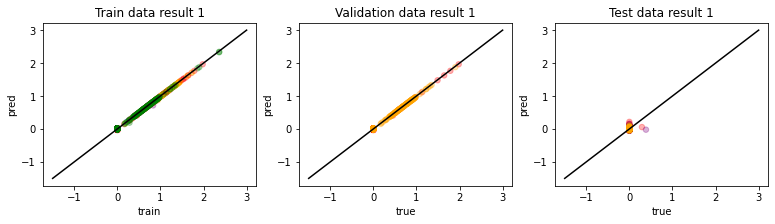

Epoch  18100 Train_loss:  0.0031264906  Validation_loss:  0.003222847  Test_loss:  0.03260628
Epoch  18200 Train_loss:  0.0030916734  Validation_loss:  0.0031804563  Test_loss:  0.032594595
Epoch  18300 Train_loss:  0.0030741193  Validation_loss:  0.0031607102  Test_loss:  0.032567196
Epoch  18400 Train_loss:  0.003062783  Validation_loss:  0.0031624676  Test_loss:  0.032520656
Epoch  18500 Train_loss:  0.0030831897  Validation_loss:  0.0032044488  Test_loss:  0.032466237
Epoch  18600 Train_loss:  0.0030225988  Validation_loss:  0.0031093876  Test_loss:  0.032469865
Epoch  18700 Train_loss:  0.0030165506  Validation_loss:  0.0031069191  Test_loss:  0.03244137
Epoch  18800 Train_loss:  0.0030395894  Validation_loss:  0.0031451767  Test_loss:  0.032381948
Epoch  18900 Train_loss:  0.0030037195  Validation_loss:  0.0030921549  Test_loss:  0.03236737
Epoch  19000 Train_loss:  0.0029740199  Validation_loss:  0.0030611525  Test_loss:  0.03235557


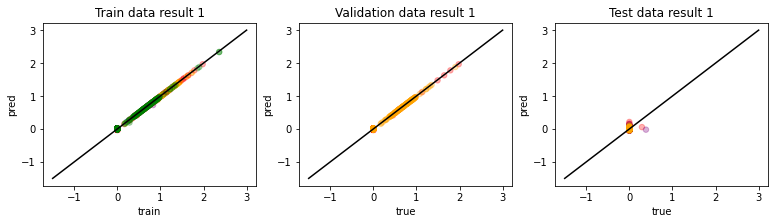

Epoch  19100 Train_loss:  0.0030246722  Validation_loss:  0.003145408  Test_loss:  0.032264464
Epoch  19200 Train_loss:  0.0029603222  Validation_loss:  0.003065383  Test_loss:  0.03228779
Epoch  19300 Train_loss:  0.0029521955  Validation_loss:  0.0030571686  Test_loss:  0.03224745
Epoch  19400 Train_loss:  0.0029662866  Validation_loss:  0.003080369  Test_loss:  0.03218668
Epoch  19500 Train_loss:  0.002966056  Validation_loss:  0.00307352  Test_loss:  0.03215512
Epoch  19600 Train_loss:  0.0028829263  Validation_loss:  0.0029632451  Test_loss:  0.032170024
Epoch  19700 Train_loss:  0.0028619785  Validation_loss:  0.0029417211  Test_loss:  0.032145217
Epoch  19800 Train_loss:  0.002926595  Validation_loss:  0.0030406024  Test_loss:  0.032059178
Epoch  19900 Train_loss:  0.00285786  Validation_loss:  0.002948858  Test_loss:  0.032068588
Epoch  20000 Train_loss:  0.0029245575  Validation_loss:  0.0030448693  Test_loss:  0.031967044


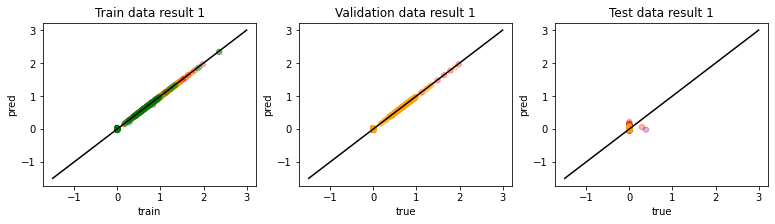

Epoch  20100 Train_loss:  0.0028780936  Validation_loss:  0.0029902332  Test_loss:  0.03197074
Epoch  20200 Train_loss:  0.0029431968  Validation_loss:  0.0030778851  Test_loss:  0.031907924
Epoch  20300 Train_loss:  0.0029198048  Validation_loss:  0.003045481  Test_loss:  0.031895623
Epoch  20400 Train_loss:  0.0028762917  Validation_loss:  0.0029879084  Test_loss:  0.031865872
Epoch  20500 Train_loss:  0.002850425  Validation_loss:  0.0029608742  Test_loss:  0.031853605
Epoch  20600 Train_loss:  0.0028680728  Validation_loss:  0.003000035  Test_loss:  0.03181573
Epoch  20700 Train_loss:  0.0028294418  Validation_loss:  0.0029511277  Test_loss:  0.031787477
Epoch  20800 Train_loss:  0.0028172159  Validation_loss:  0.0029374852  Test_loss:  0.031777993
Epoch  20900 Train_loss:  0.0028313464  Validation_loss:  0.0029514357  Test_loss:  0.03172316
Epoch  21000 Train_loss:  0.0027886522  Validation_loss:  0.0029050356  Test_loss:  0.03172706


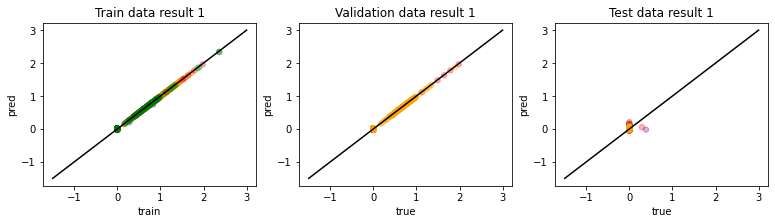

Epoch  21100 Train_loss:  0.0027552857  Validation_loss:  0.0028529363  Test_loss:  0.03173362
Epoch  21200 Train_loss:  0.002798446  Validation_loss:  0.0029142043  Test_loss:  0.03165035
Epoch  21300 Train_loss:  0.002781668  Validation_loss:  0.0028849342  Test_loss:  0.031614047
Epoch  21400 Train_loss:  0.0027560485  Validation_loss:  0.0028631543  Test_loss:  0.03161432
Epoch  21500 Train_loss:  0.0027795995  Validation_loss:  0.0028846946  Test_loss:  0.03157977
Epoch  21600 Train_loss:  0.0027077731  Validation_loss:  0.002799568  Test_loss:  0.031583894
Epoch  21700 Train_loss:  0.0026946678  Validation_loss:  0.0027942557  Test_loss:  0.031558763
Epoch  21800 Train_loss:  0.002739315  Validation_loss:  0.0028494515  Test_loss:  0.031480487
Epoch  21900 Train_loss:  0.0026939781  Validation_loss:  0.0027888198  Test_loss:  0.031494517
Epoch  22000 Train_loss:  0.0027626492  Validation_loss:  0.0028869312  Test_loss:  0.03141973


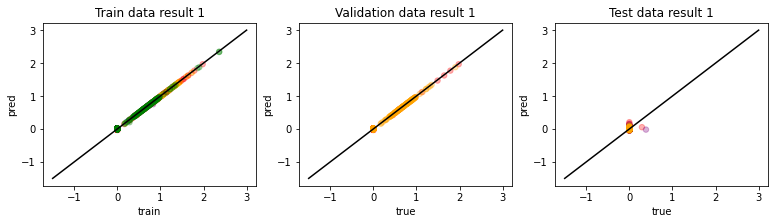

Epoch  22100 Train_loss:  0.0027078746  Validation_loss:  0.00282719  Test_loss:  0.03140898
Epoch  22200 Train_loss:  0.0026857702  Validation_loss:  0.002806396  Test_loss:  0.03138966
Epoch  22300 Train_loss:  0.002726568  Validation_loss:  0.002867389  Test_loss:  0.031337626
Epoch  22400 Train_loss:  0.0027194049  Validation_loss:  0.0028479774  Test_loss:  0.03132698
Epoch  22500 Train_loss:  0.0026254228  Validation_loss:  0.002707844  Test_loss:  0.03136015
Epoch  22600 Train_loss:  0.0027164302  Validation_loss:  0.0028482957  Test_loss:  0.031264123
Epoch  22700 Train_loss:  0.0026692231  Validation_loss:  0.002787227  Test_loss:  0.03127241
Epoch  22800 Train_loss:  0.0026365898  Validation_loss:  0.0027519027  Test_loss:  0.03125936
Epoch  22900 Train_loss:  0.0026683337  Validation_loss:  0.002798751  Test_loss:  0.031210124
Epoch  23000 Train_loss:  0.0026399852  Validation_loss:  0.0027630576  Test_loss:  0.031195635


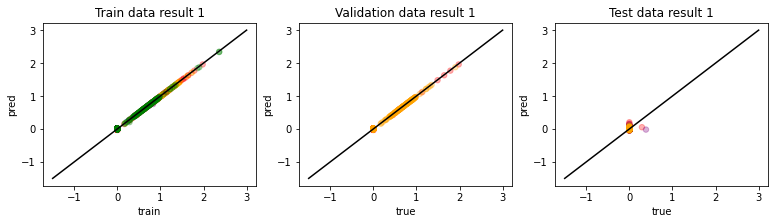

Epoch  23100 Train_loss:  0.0025717092  Validation_loss:  0.0026835785  Test_loss:  0.03121112
Epoch  23200 Train_loss:  0.002579356  Validation_loss:  0.0026964548  Test_loss:  0.031163853
Epoch  23300 Train_loss:  0.0025690545  Validation_loss:  0.0026765254  Test_loss:  0.031140843
Epoch  23400 Train_loss:  0.0026642075  Validation_loss:  0.0028061685  Test_loss:  0.031055171
Epoch  23500 Train_loss:  0.0026014836  Validation_loss:  0.0027178093  Test_loss:  0.031067863
Epoch  23600 Train_loss:  0.0025768005  Validation_loss:  0.002691681  Test_loss:  0.031062415
Epoch  23700 Train_loss:  0.0025875883  Validation_loss:  0.0027103033  Test_loss:  0.031013915
Epoch  23800 Train_loss:  0.0025918586  Validation_loss:  0.0027239807  Test_loss:  0.03099168
Epoch  23900 Train_loss:  0.0025958386  Validation_loss:  0.0027383205  Test_loss:  0.030955348
Epoch  24000 Train_loss:  0.002547594  Validation_loss:  0.002678806  Test_loss:  0.030970966


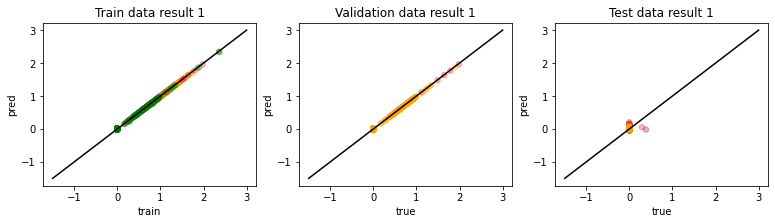

Epoch  24100 Train_loss:  0.0025201172  Validation_loss:  0.0026501394  Test_loss:  0.030958459
Epoch  24200 Train_loss:  0.0025316975  Validation_loss:  0.0026619667  Test_loss:  0.03091768
Epoch  24300 Train_loss:  0.002506756  Validation_loss:  0.0026291846  Test_loss:  0.030928768
Epoch  24400 Train_loss:  0.0025026249  Validation_loss:  0.0026267532  Test_loss:  0.03088631
Epoch  24500 Train_loss:  0.0025480231  Validation_loss:  0.0026936827  Test_loss:  0.030835949
Epoch  24600 Train_loss:  0.00248805  Validation_loss:  0.0026107985  Test_loss:  0.030836334
Epoch  24700 Train_loss:  0.0025627392  Validation_loss:  0.0027217113  Test_loss:  0.030761937
Epoch  24800 Train_loss:  0.0024351047  Validation_loss:  0.0025404675  Test_loss:  0.030822756
Epoch  24900 Train_loss:  0.0025013154  Validation_loss:  0.0026470874  Test_loss:  0.030750928
Epoch  25000 Train_loss:  0.002469173  Validation_loss:  0.0026134774  Test_loss:  0.030770402


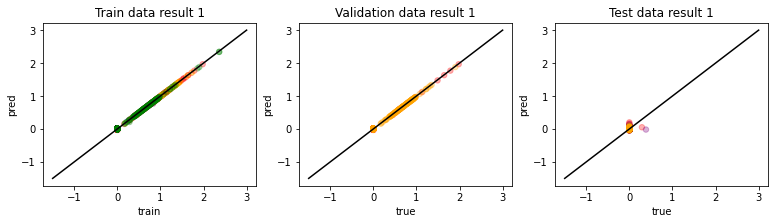

Epoch  25100 Train_loss:  0.0024169197  Validation_loss:  0.002546798  Test_loss:  0.030753583
Epoch  25200 Train_loss:  0.0024732472  Validation_loss:  0.0026347777  Test_loss:  0.03069663
Epoch  25300 Train_loss:  0.0024524888  Validation_loss:  0.002611088  Test_loss:  0.030683458
Epoch  25400 Train_loss:  0.0024193265  Validation_loss:  0.002560668  Test_loss:  0.030680293
Epoch  25500 Train_loss:  0.002480054  Validation_loss:  0.0026512991  Test_loss:  0.030609597
Epoch  25600 Train_loss:  0.0024006602  Validation_loss:  0.002544298  Test_loss:  0.03063911
Epoch  25700 Train_loss:  0.0023901432  Validation_loss:  0.002518419  Test_loss:  0.030642284
Epoch  25800 Train_loss:  0.00241751  Validation_loss:  0.0025676668  Test_loss:  0.0305686
Epoch  25900 Train_loss:  0.0024795097  Validation_loss:  0.0026680573  Test_loss:  0.030517599
Epoch  26000 Train_loss:  0.0024971538  Validation_loss:  0.0026734702  Test_loss:  0.030490411


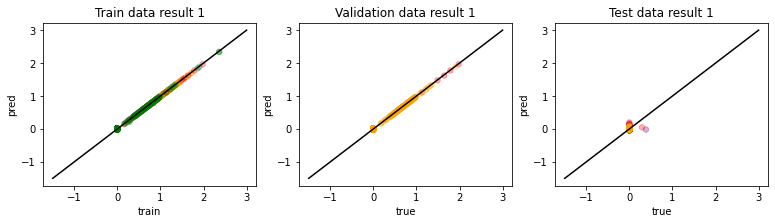

Epoch  26100 Train_loss:  0.002454306  Validation_loss:  0.002612721  Test_loss:  0.030493762
Epoch  26200 Train_loss:  0.0024174252  Validation_loss:  0.0025592172  Test_loss:  0.030496534
Epoch  26300 Train_loss:  0.0024293056  Validation_loss:  0.0025778436  Test_loss:  0.030445356
Epoch  26400 Train_loss:  0.0023849981  Validation_loss:  0.002513467  Test_loss:  0.03047259
Epoch  26500 Train_loss:  0.0023732092  Validation_loss:  0.0024981927  Test_loss:  0.030464737
Epoch  26600 Train_loss:  0.00237838  Validation_loss:  0.002517628  Test_loss:  0.030416807
Epoch  26700 Train_loss:  0.0023518475  Validation_loss:  0.0024809313  Test_loss:  0.030425353
Epoch  26800 Train_loss:  0.0023407398  Validation_loss:  0.002471935  Test_loss:  0.030395867
Epoch  26900 Train_loss:  0.0023501744  Validation_loss:  0.0024842194  Test_loss:  0.030360911
Epoch  27000 Train_loss:  0.0022894037  Validation_loss:  0.002408641  Test_loss:  0.030387841


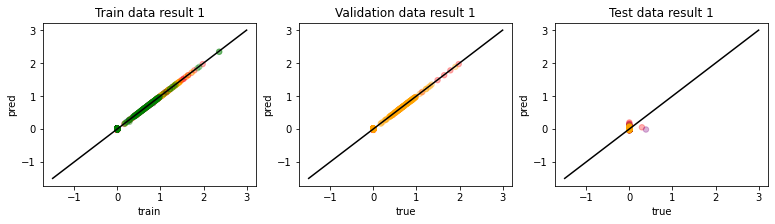

Epoch  27100 Train_loss:  0.002316562  Validation_loss:  0.0024384027  Test_loss:  0.030350732
Epoch  27200 Train_loss:  0.0023116847  Validation_loss:  0.0024325955  Test_loss:  0.030333228
Epoch  27300 Train_loss:  0.0023063344  Validation_loss:  0.0024431038  Test_loss:  0.030322477
Epoch  27400 Train_loss:  0.0023765757  Validation_loss:  0.0025228092  Test_loss:  0.03026359
Epoch  27500 Train_loss:  0.0023123852  Validation_loss:  0.0024344383  Test_loss:  0.030280894
Epoch  27600 Train_loss:  0.0023707794  Validation_loss:  0.0025082116  Test_loss:  0.030200304
Epoch  27700 Train_loss:  0.002351608  Validation_loss:  0.0024860445  Test_loss:  0.03020638
Epoch  27800 Train_loss:  0.0023303668  Validation_loss:  0.0024630795  Test_loss:  0.030199226
Epoch  27900 Train_loss:  0.002323595  Validation_loss:  0.0024515663  Test_loss:  0.03017803
Epoch  28000 Train_loss:  0.0022621795  Validation_loss:  0.0023781129  Test_loss:  0.030197022


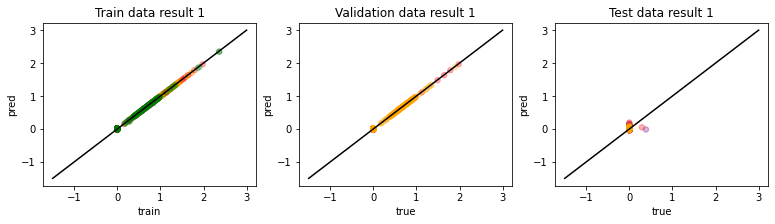

Epoch  28100 Train_loss:  0.002261314  Validation_loss:  0.0023724083  Test_loss:  0.03017345
Epoch  28200 Train_loss:  0.0023616825  Validation_loss:  0.0025051695  Test_loss:  0.03009974
Epoch  28300 Train_loss:  0.0023149303  Validation_loss:  0.002456693  Test_loss:  0.030106239
Epoch  28400 Train_loss:  0.002304847  Validation_loss:  0.0024449348  Test_loss:  0.030090021
Epoch  28500 Train_loss:  0.0022694594  Validation_loss:  0.002398986  Test_loss:  0.030111898
Epoch  28600 Train_loss:  0.0023749026  Validation_loss:  0.0025357145  Test_loss:  0.030020947
Epoch  28700 Train_loss:  0.0022556386  Validation_loss:  0.0023638555  Test_loss:  0.030062558
Epoch  28800 Train_loss:  0.0023152526  Validation_loss:  0.0024485094  Test_loss:  0.030026132
Epoch  28900 Train_loss:  0.002249131  Validation_loss:  0.002356549  Test_loss:  0.030029435
Epoch  29000 Train_loss:  0.0022495338  Validation_loss:  0.0023671538  Test_loss:  0.030019676


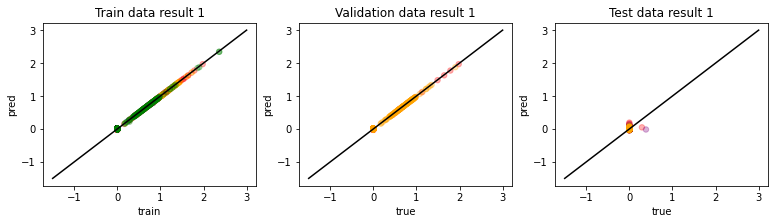

Epoch  29100 Train_loss:  0.0022533133  Validation_loss:  0.002383505  Test_loss:  0.030012328
Epoch  29200 Train_loss:  0.00221655  Validation_loss:  0.0023390665  Test_loss:  0.0299658
Epoch  29300 Train_loss:  0.0022770215  Validation_loss:  0.0024237726  Test_loss:  0.029939577
Epoch  29400 Train_loss:  0.00225464  Validation_loss:  0.0023969773  Test_loss:  0.029947137
Epoch  29500 Train_loss:  0.0022809852  Validation_loss:  0.0024208247  Test_loss:  0.029921226
Epoch  29600 Train_loss:  0.0022230712  Validation_loss:  0.0023463657  Test_loss:  0.029919695
Epoch  29700 Train_loss:  0.0022222109  Validation_loss:  0.002359253  Test_loss:  0.02989782
Epoch  29800 Train_loss:  0.0023010196  Validation_loss:  0.002459483  Test_loss:  0.02983833
Epoch  29900 Train_loss:  0.0021854744  Validation_loss:  0.0023035773  Test_loss:  0.029887779
Epoch  30000 Train_loss:  0.002196175  Validation_loss:  0.0023161254  Test_loss:  0.029857963


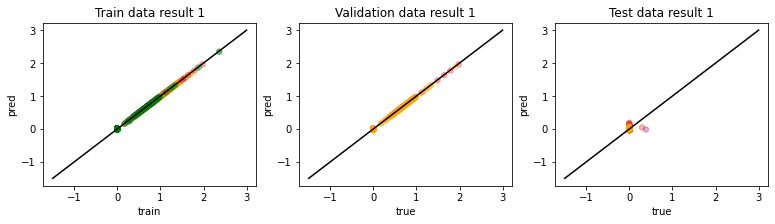

Epoch  30100 Train_loss:  0.002286819  Validation_loss:  0.0024208245  Test_loss:  0.029788954
Epoch  30200 Train_loss:  0.0021918358  Validation_loss:  0.0023026224  Test_loss:  0.029817682
Epoch  30300 Train_loss:  0.0022246926  Validation_loss:  0.0023429308  Test_loss:  0.029784739
Epoch  30400 Train_loss:  0.0022375756  Validation_loss:  0.0023632632  Test_loss:  0.02977162
Epoch  30500 Train_loss:  0.0022772003  Validation_loss:  0.0024248227  Test_loss:  0.029728727
Epoch  30600 Train_loss:  0.0021947294  Validation_loss:  0.002321218  Test_loss:  0.029730478
Epoch  30700 Train_loss:  0.0021674088  Validation_loss:  0.002299576  Test_loss:  0.029748632
Epoch  30800 Train_loss:  0.0022008116  Validation_loss:  0.0023419773  Test_loss:  0.02970985
Epoch  30900 Train_loss:  0.0022032764  Validation_loss:  0.0023508603  Test_loss:  0.029672997
Epoch  31000 Train_loss:  0.0021596088  Validation_loss:  0.002306431  Test_loss:  0.02968884


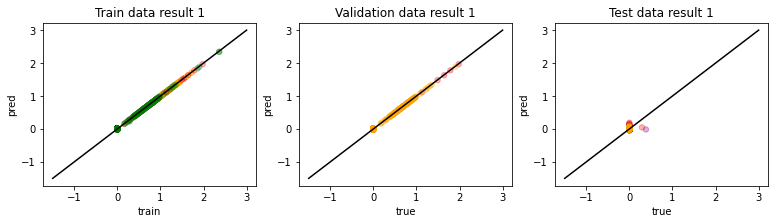

Epoch  31100 Train_loss:  0.0021799693  Validation_loss:  0.002334115  Test_loss:  0.02967648
Epoch  31200 Train_loss:  0.0021093828  Validation_loss:  0.00223611  Test_loss:  0.029677026
Epoch  31300 Train_loss:  0.0021918723  Validation_loss:  0.002344714  Test_loss:  0.029615924
Epoch  31400 Train_loss:  0.002194049  Validation_loss:  0.002342955  Test_loss:  0.02961937
Epoch  31500 Train_loss:  0.0020769187  Validation_loss:  0.002176637  Test_loss:  0.029670216
Epoch  31600 Train_loss:  0.0021278576  Validation_loss:  0.002255518  Test_loss:  0.02960463
Epoch  31700 Train_loss:  0.002167331  Validation_loss:  0.002319326  Test_loss:  0.029589573
Epoch  31800 Train_loss:  0.002145655  Validation_loss:  0.0022771368  Test_loss:  0.029564388
Epoch  31900 Train_loss:  0.0020979089  Validation_loss:  0.002216627  Test_loss:  0.029590474
Epoch  32000 Train_loss:  0.0021050558  Validation_loss:  0.0022347877  Test_loss:  0.029536776


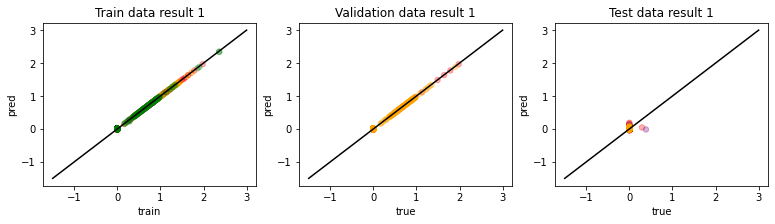

Epoch  32100 Train_loss:  0.002138843  Validation_loss:  0.002258517  Test_loss:  0.029501999
Epoch  32200 Train_loss:  0.0021775346  Validation_loss:  0.0023121976  Test_loss:  0.029481886
Epoch  32300 Train_loss:  0.0021201351  Validation_loss:  0.0022462432  Test_loss:  0.029502634
Epoch  32400 Train_loss:  0.0020919025  Validation_loss:  0.0022182437  Test_loss:  0.02950863
Epoch  32500 Train_loss:  0.0021124706  Validation_loss:  0.0022570768  Test_loss:  0.029479573
Epoch  32600 Train_loss:  0.002108758  Validation_loss:  0.0022336124  Test_loss:  0.02945598
Epoch  32700 Train_loss:  0.0021117264  Validation_loss:  0.0022428113  Test_loss:  0.029440004
Epoch  32800 Train_loss:  0.002112584  Validation_loss:  0.0022454783  Test_loss:  0.029439762
Epoch  32900 Train_loss:  0.0021048652  Validation_loss:  0.002212499  Test_loss:  0.029434385
Epoch  33000 Train_loss:  0.0021458482  Validation_loss:  0.002262766  Test_loss:  0.029359959


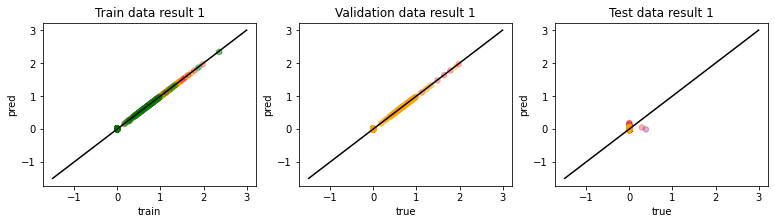

Epoch  33100 Train_loss:  0.0020396695  Validation_loss:  0.0021269892  Test_loss:  0.02942302
Epoch  33200 Train_loss:  0.0020809313  Validation_loss:  0.0021911387  Test_loss:  0.02939414
Epoch  33300 Train_loss:  0.002131608  Validation_loss:  0.0022648065  Test_loss:  0.02933306
Epoch  33400 Train_loss:  0.0020921445  Validation_loss:  0.0022164765  Test_loss:  0.029333163
Epoch  33500 Train_loss:  0.0020628949  Validation_loss:  0.00217603  Test_loss:  0.029355
Epoch  33600 Train_loss:  0.0020414947  Validation_loss:  0.0021456787  Test_loss:  0.029337456
Epoch  33700 Train_loss:  0.0020255032  Validation_loss:  0.0021223323  Test_loss:  0.02933042
Epoch  33800 Train_loss:  0.002067755  Validation_loss:  0.0021828853  Test_loss:  0.029314017
Epoch  33900 Train_loss:  0.0020504913  Validation_loss:  0.0021538856  Test_loss:  0.029302947
Epoch  34000 Train_loss:  0.002053682  Validation_loss:  0.0021650405  Test_loss:  0.029292934


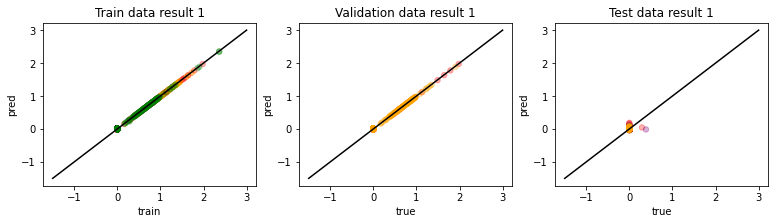

Epoch  34100 Train_loss:  0.0020282348  Validation_loss:  0.0021422373  Test_loss:  0.029278724
Epoch  34200 Train_loss:  0.0019824957  Validation_loss:  0.002077755  Test_loss:  0.029289845
Epoch  34300 Train_loss:  0.002000295  Validation_loss:  0.0020988134  Test_loss:  0.02927194
Epoch  34400 Train_loss:  0.0020595915  Validation_loss:  0.0022073037  Test_loss:  0.02920927
Epoch  34500 Train_loss:  0.0020194808  Validation_loss:  0.0021534937  Test_loss:  0.02922055
Epoch  34600 Train_loss:  0.001993325  Validation_loss:  0.00212059  Test_loss:  0.029233139
Epoch  34700 Train_loss:  0.0020278345  Validation_loss:  0.0021681734  Test_loss:  0.029194426
Epoch  34800 Train_loss:  0.0019594338  Validation_loss:  0.0020739995  Test_loss:  0.029205715
Epoch  34900 Train_loss:  0.001972585  Validation_loss:  0.0020859553  Test_loss:  0.02920846
Epoch  35000 Train_loss:  0.0020666774  Validation_loss:  0.002220281  Test_loss:  0.029130597


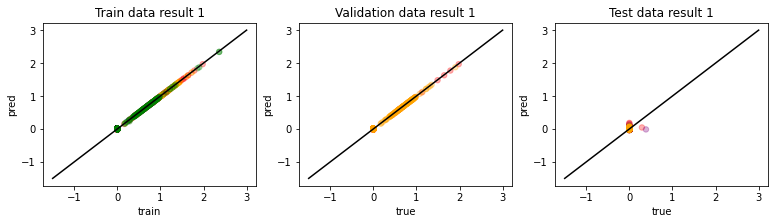

Epoch  35100 Train_loss:  0.0019824884  Validation_loss:  0.0021108214  Test_loss:  0.029160807
Epoch  35200 Train_loss:  0.0020195115  Validation_loss:  0.002163544  Test_loss:  0.029127268
Epoch  35300 Train_loss:  0.0020261733  Validation_loss:  0.002161082  Test_loss:  0.02911637
Epoch  35400 Train_loss:  0.0020128393  Validation_loss:  0.0021246825  Test_loss:  0.029104905
Epoch  35500 Train_loss:  0.0020031699  Validation_loss:  0.002114104  Test_loss:  0.02907446
Epoch  35600 Train_loss:  0.0019734816  Validation_loss:  0.0020669517  Test_loss:  0.029072652
Epoch  35700 Train_loss:  0.0020212203  Validation_loss:  0.0021388563  Test_loss:  0.029056758
Epoch  35800 Train_loss:  0.0020118097  Validation_loss:  0.0021468455  Test_loss:  0.02905923
Epoch  35900 Train_loss:  0.00195818  Validation_loss:  0.0020677105  Test_loss:  0.02906536
Epoch  36000 Train_loss:  0.001993223  Validation_loss:  0.0021201305  Test_loss:  0.02902858


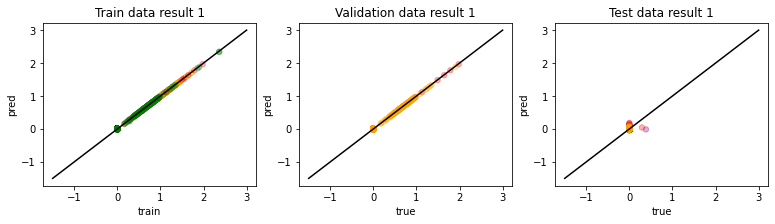

Epoch  36100 Train_loss:  0.0019996532  Validation_loss:  0.002119665  Test_loss:  0.029015036
Epoch  36200 Train_loss:  0.0020021428  Validation_loss:  0.0021265124  Test_loss:  0.029004836
Epoch  36300 Train_loss:  0.0020438523  Validation_loss:  0.0021836252  Test_loss:  0.028973801
Epoch  36400 Train_loss:  0.0019694397  Validation_loss:  0.0020809127  Test_loss:  0.028980339
Epoch  36500 Train_loss:  0.0019502785  Validation_loss:  0.0020583272  Test_loss:  0.028968409
Epoch  36600 Train_loss:  0.001951661  Validation_loss:  0.0020724882  Test_loss:  0.02895567
Epoch  36700 Train_loss:  0.0019851425  Validation_loss:  0.0021040728  Test_loss:  0.028959299
Epoch  36800 Train_loss:  0.0020087636  Validation_loss:  0.002140439  Test_loss:  0.028928
Epoch  36900 Train_loss:  0.001942825  Validation_loss:  0.0020633163  Test_loss:  0.028952664
Epoch  37000 Train_loss:  0.0019111966  Validation_loss:  0.0020177888  Test_loss:  0.028956974


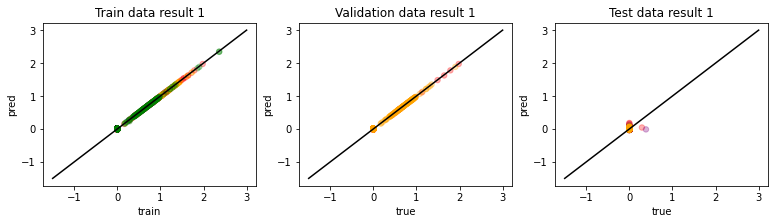

Epoch  37100 Train_loss:  0.001966001  Validation_loss:  0.002097709  Test_loss:  0.0289144
Epoch  37200 Train_loss:  0.0019210292  Validation_loss:  0.0020393662  Test_loss:  0.028925547
Epoch  37300 Train_loss:  0.001922844  Validation_loss:  0.002030959  Test_loss:  0.028892638
Epoch  37400 Train_loss:  0.0019550694  Validation_loss:  0.0020614471  Test_loss:  0.028870566
Epoch  37500 Train_loss:  0.0019542633  Validation_loss:  0.0020708828  Test_loss:  0.028872842
Epoch  37600 Train_loss:  0.0019262853  Validation_loss:  0.0020369084  Test_loss:  0.028857836
Epoch  37700 Train_loss:  0.0019356038  Validation_loss:  0.0020388337  Test_loss:  0.028837599
Epoch  37800 Train_loss:  0.0019436772  Validation_loss:  0.0020446118  Test_loss:  0.028853273
Epoch  37900 Train_loss:  0.0019441062  Validation_loss:  0.0020564157  Test_loss:  0.028813938
Epoch  38000 Train_loss:  0.0018842285  Validation_loss:  0.0019836847  Test_loss:  0.028823107


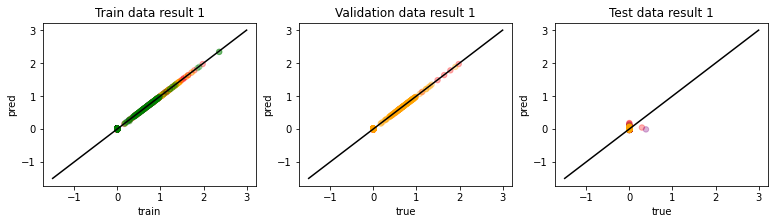

Epoch  38100 Train_loss:  0.0019404382  Validation_loss:  0.0020638185  Test_loss:  0.028803216
Epoch  38200 Train_loss:  0.0018650928  Validation_loss:  0.0019768567  Test_loss:  0.028797988
Epoch  38300 Train_loss:  0.001905726  Validation_loss:  0.0020291212  Test_loss:  0.02877972
Epoch  38400 Train_loss:  0.001959118  Validation_loss:  0.0020980085  Test_loss:  0.02873471
Epoch  38500 Train_loss:  0.0019285401  Validation_loss:  0.0020526855  Test_loss:  0.028743943
Epoch  38600 Train_loss:  0.0019812188  Validation_loss:  0.0021312286  Test_loss:  0.028718967
Epoch  38700 Train_loss:  0.0019136459  Validation_loss:  0.002025924  Test_loss:  0.02877799
Epoch  38800 Train_loss:  0.0018437412  Validation_loss:  0.0019329647  Test_loss:  0.028777407
Epoch  38900 Train_loss:  0.001871234  Validation_loss:  0.0019661812  Test_loss:  0.028749255
Epoch  39000 Train_loss:  0.0018794298  Validation_loss:  0.0019775578  Test_loss:  0.028715791


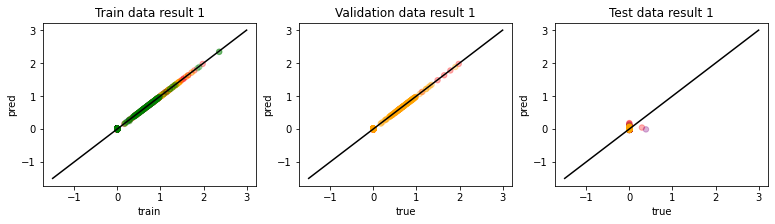

Epoch  39100 Train_loss:  0.0019209421  Validation_loss:  0.0020420686  Test_loss:  0.02868586
Epoch  39200 Train_loss:  0.0019661828  Validation_loss:  0.0021013701  Test_loss:  0.028652802
Epoch  39300 Train_loss:  0.0018788052  Validation_loss:  0.0020070798  Test_loss:  0.028694516
Epoch  39400 Train_loss:  0.0018710619  Validation_loss:  0.0019720763  Test_loss:  0.028689058
Epoch  39500 Train_loss:  0.0018363341  Validation_loss:  0.001926866  Test_loss:  0.028685994
Epoch  39600 Train_loss:  0.0019121043  Validation_loss:  0.002026226  Test_loss:  0.028620997
Epoch  39700 Train_loss:  0.0018866621  Validation_loss:  0.0019790602  Test_loss:  0.028643081
Epoch  39800 Train_loss:  0.0018818633  Validation_loss:  0.0019719286  Test_loss:  0.02862083
Epoch  39900 Train_loss:  0.0018808554  Validation_loss:  0.0019852375  Test_loss:  0.028609391
Epoch  40000 Train_loss:  0.0018502385  Validation_loss:  0.0019468224  Test_loss:  0.028616706


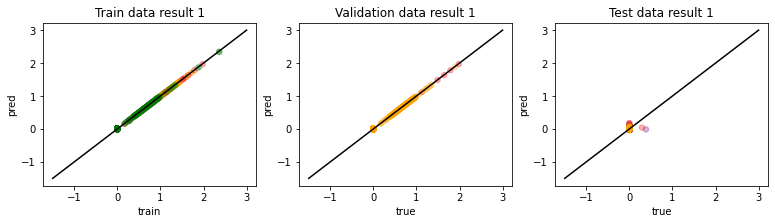

Epoch  40100 Train_loss:  0.0018595587  Validation_loss:  0.0019769825  Test_loss:  0.02862073
Epoch  40200 Train_loss:  0.0019503082  Validation_loss:  0.0020837435  Test_loss:  0.02854589
Epoch  40300 Train_loss:  0.0019631158  Validation_loss:  0.0021106335  Test_loss:  0.028530272
Epoch  40400 Train_loss:  0.0018503561  Validation_loss:  0.0019616408  Test_loss:  0.028590573
Epoch  40500 Train_loss:  0.0018800297  Validation_loss:  0.0020015058  Test_loss:  0.028541084
Epoch  40600 Train_loss:  0.001796575  Validation_loss:  0.0018676004  Test_loss:  0.028587867
Epoch  40700 Train_loss:  0.0018202289  Validation_loss:  0.0019093408  Test_loss:  0.028552867
Epoch  40800 Train_loss:  0.0018224391  Validation_loss:  0.001928499  Test_loss:  0.028542966
Epoch  40900 Train_loss:  0.0018489744  Validation_loss:  0.0019656406  Test_loss:  0.028530056
Epoch  41000 Train_loss:  0.0018325818  Validation_loss:  0.0019439829  Test_loss:  0.028498592


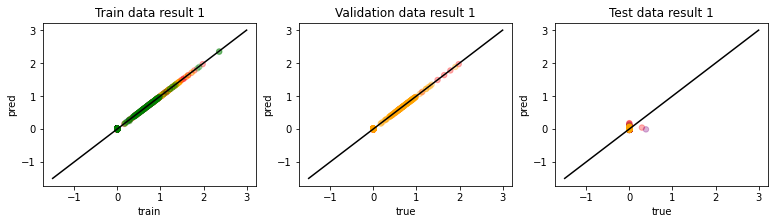

Epoch  41100 Train_loss:  0.0018919643  Validation_loss:  0.0020373445  Test_loss:  0.028482435
Epoch  41200 Train_loss:  0.0017726762  Validation_loss:  0.0018713898  Test_loss:  0.028522976
Epoch  41300 Train_loss:  0.0018727201  Validation_loss:  0.0019998457  Test_loss:  0.028474664
Epoch  41400 Train_loss:  0.0018143544  Validation_loss:  0.0019178261  Test_loss:  0.028483465
Epoch  41500 Train_loss:  0.001775352  Validation_loss:  0.0018758046  Test_loss:  0.02848965
Epoch  41600 Train_loss:  0.0018119146  Validation_loss:  0.0019183144  Test_loss:  0.028459806
Epoch  41700 Train_loss:  0.0017944487  Validation_loss:  0.0019009887  Test_loss:  0.028488066
Epoch  41800 Train_loss:  0.0018339611  Validation_loss:  0.0019554915  Test_loss:  0.0284536
Epoch  41900 Train_loss:  0.0018397318  Validation_loss:  0.0019438019  Test_loss:  0.028440043
Epoch  42000 Train_loss:  0.0018048305  Validation_loss:  0.0019100667  Test_loss:  0.0284182


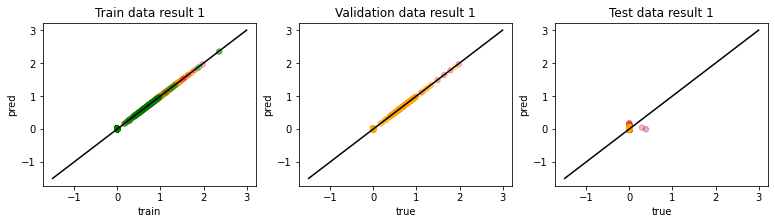

Epoch  42100 Train_loss:  0.0018681602  Validation_loss:  0.001984251  Test_loss:  0.028390383
Epoch  42200 Train_loss:  0.0018360015  Validation_loss:  0.0019510064  Test_loss:  0.028406065
Epoch  42300 Train_loss:  0.0017863314  Validation_loss:  0.0018869622  Test_loss:  0.028409157
Epoch  42400 Train_loss:  0.0018117622  Validation_loss:  0.0019189706  Test_loss:  0.028408803
Epoch  42500 Train_loss:  0.0017671419  Validation_loss:  0.001866192  Test_loss:  0.02841624
Epoch  42600 Train_loss:  0.0017992086  Validation_loss:  0.001901156  Test_loss:  0.028392099
Epoch  42700 Train_loss:  0.0017844466  Validation_loss:  0.0018825082  Test_loss:  0.028385123
Epoch  42800 Train_loss:  0.0017992135  Validation_loss:  0.0019211093  Test_loss:  0.028353533
Epoch  42900 Train_loss:  0.0018290733  Validation_loss:  0.0019668434  Test_loss:  0.028316105
Epoch  43000 Train_loss:  0.0017309925  Validation_loss:  0.0018309687  Test_loss:  0.028361112


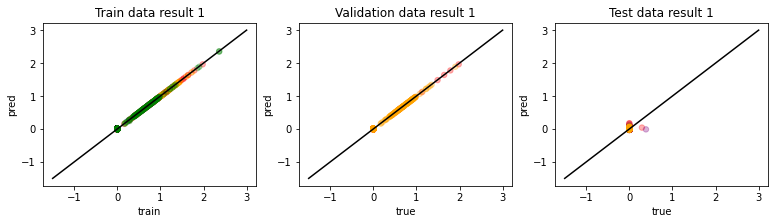

Epoch  43100 Train_loss:  0.0017805301  Validation_loss:  0.0018933476  Test_loss:  0.028317655
Epoch  43200 Train_loss:  0.0017564711  Validation_loss:  0.0018615216  Test_loss:  0.028354151
Epoch  43300 Train_loss:  0.0017983522  Validation_loss:  0.0019264251  Test_loss:  0.028304802
Epoch  43400 Train_loss:  0.0018694272  Validation_loss:  0.0020077066  Test_loss:  0.028254658
Epoch  43500 Train_loss:  0.0017685401  Validation_loss:  0.0018705055  Test_loss:  0.028315384
Epoch  43600 Train_loss:  0.0018082318  Validation_loss:  0.0019313045  Test_loss:  0.028293187
Epoch  43700 Train_loss:  0.0017878616  Validation_loss:  0.0019065515  Test_loss:  0.028284932
Epoch  43800 Train_loss:  0.0017418006  Validation_loss:  0.0018520453  Test_loss:  0.028304353
Epoch  43900 Train_loss:  0.001829436  Validation_loss:  0.0019690653  Test_loss:  0.028230753
Epoch  44000 Train_loss:  0.0017775596  Validation_loss:  0.0018990833  Test_loss:  0.028245557


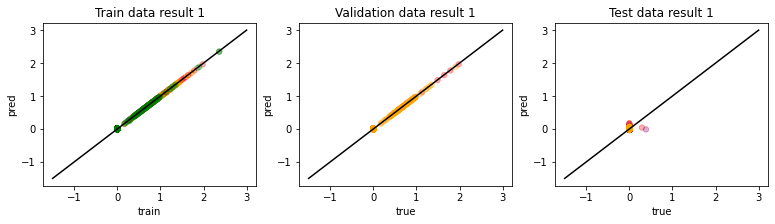

Epoch  44100 Train_loss:  0.001760203  Validation_loss:  0.001869815  Test_loss:  0.028253296
Epoch  44200 Train_loss:  0.0017328382  Validation_loss:  0.0018351885  Test_loss:  0.028270664
Epoch  44300 Train_loss:  0.0017432162  Validation_loss:  0.0018576579  Test_loss:  0.028258247
Epoch  44400 Train_loss:  0.0017259064  Validation_loss:  0.0018267609  Test_loss:  0.02827942
Epoch  44500 Train_loss:  0.0017550113  Validation_loss:  0.001878499  Test_loss:  0.028228715
Epoch  44600 Train_loss:  0.001783388  Validation_loss:  0.0019308433  Test_loss:  0.028214391
Epoch  44700 Train_loss:  0.0017758727  Validation_loss:  0.001907298  Test_loss:  0.028203249
Epoch  44800 Train_loss:  0.001759448  Validation_loss:  0.0018882616  Test_loss:  0.028202863
Epoch  44900 Train_loss:  0.0017655336  Validation_loss:  0.0018870413  Test_loss:  0.028182812
Epoch  45000 Train_loss:  0.001696593  Validation_loss:  0.0018074625  Test_loss:  0.028219178


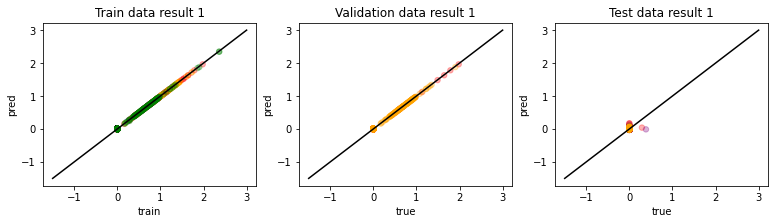

Epoch  45100 Train_loss:  0.001708864  Validation_loss:  0.0018262921  Test_loss:  0.028201116
Epoch  45200 Train_loss:  0.0017560591  Validation_loss:  0.0018990904  Test_loss:  0.028173063
Epoch  45300 Train_loss:  0.0017998664  Validation_loss:  0.001954875  Test_loss:  0.028144982
Epoch  45400 Train_loss:  0.0017880943  Validation_loss:  0.0019338131  Test_loss:  0.02813769
Epoch  45500 Train_loss:  0.001741081  Validation_loss:  0.0018751485  Test_loss:  0.02814396
Epoch  45600 Train_loss:  0.0017869896  Validation_loss:  0.0019354398  Test_loss:  0.028104372
Epoch  45700 Train_loss:  0.0017501914  Validation_loss:  0.001892693  Test_loss:  0.02811757
Epoch  45800 Train_loss:  0.0017572828  Validation_loss:  0.0018864574  Test_loss:  0.028107367
Epoch  45900 Train_loss:  0.0017043034  Validation_loss:  0.0018149739  Test_loss:  0.028149495
Epoch  46000 Train_loss:  0.0018017787  Validation_loss:  0.0019648438  Test_loss:  0.028055478


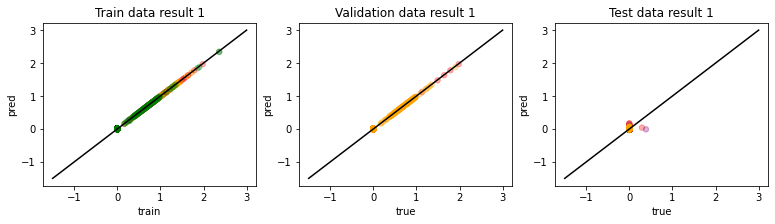

Epoch  46100 Train_loss:  0.0017606472  Validation_loss:  0.0018884278  Test_loss:  0.028074685
Epoch  46200 Train_loss:  0.0017087025  Validation_loss:  0.0018223791  Test_loss:  0.028103909
Epoch  46300 Train_loss:  0.0017683932  Validation_loss:  0.0019100029  Test_loss:  0.02807959
Epoch  46400 Train_loss:  0.0017219249  Validation_loss:  0.0018416861  Test_loss:  0.028057382
Epoch  46500 Train_loss:  0.0017346629  Validation_loss:  0.001858587  Test_loss:  0.028048787
Epoch  46600 Train_loss:  0.001714725  Validation_loss:  0.0018371352  Test_loss:  0.028066961
Epoch  46700 Train_loss:  0.0017239567  Validation_loss:  0.0018439298  Test_loss:  0.028058784
Epoch  46800 Train_loss:  0.0017054643  Validation_loss:  0.0018062877  Test_loss:  0.028062927
Epoch  46900 Train_loss:  0.0017420589  Validation_loss:  0.0018631766  Test_loss:  0.028010659
Epoch  47000 Train_loss:  0.0017781967  Validation_loss:  0.0019237874  Test_loss:  0.027995586


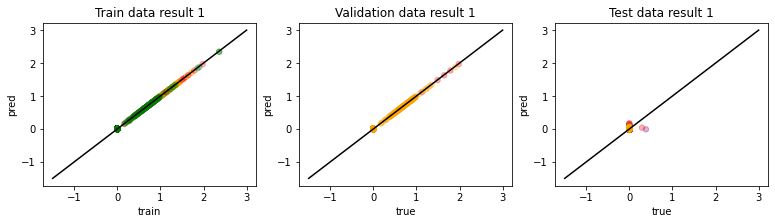

Epoch  47100 Train_loss:  0.001748286  Validation_loss:  0.0018828427  Test_loss:  0.027999882
Epoch  47200 Train_loss:  0.0017636414  Validation_loss:  0.001887434  Test_loss:  0.027981719
Epoch  47300 Train_loss:  0.0016793788  Validation_loss:  0.0017780913  Test_loss:  0.02803215
Epoch  47400 Train_loss:  0.0016652484  Validation_loss:  0.0017516209  Test_loss:  0.028023545
Epoch  47500 Train_loss:  0.0017484688  Validation_loss:  0.001863946  Test_loss:  0.02796605
Epoch  47600 Train_loss:  0.0018119894  Validation_loss:  0.0019525202  Test_loss:  0.027945211
Epoch  47700 Train_loss:  0.0017597274  Validation_loss:  0.0019017117  Test_loss:  0.027953124
Epoch  47800 Train_loss:  0.0016682798  Validation_loss:  0.0017864171  Test_loss:  0.027986031
Epoch  47900 Train_loss:  0.0017719987  Validation_loss:  0.0019159024  Test_loss:  0.027921734
Epoch  48000 Train_loss:  0.0016880156  Validation_loss:  0.0017982493  Test_loss:  0.027973078


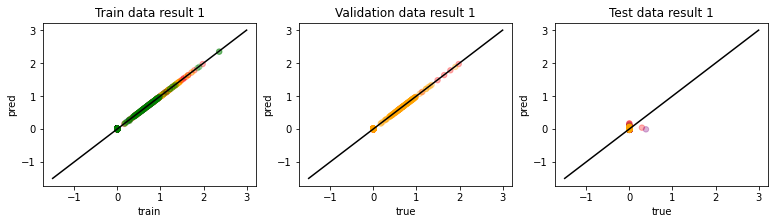

Epoch  48100 Train_loss:  0.0016804312  Validation_loss:  0.0017831034  Test_loss:  0.027942564
Epoch  48200 Train_loss:  0.0017343223  Validation_loss:  0.0018772897  Test_loss:  0.027900327
Epoch  48300 Train_loss:  0.0016764195  Validation_loss:  0.0017889652  Test_loss:  0.027925352
Epoch  48400 Train_loss:  0.001643544  Validation_loss:  0.0017452986  Test_loss:  0.027927391
Epoch  48500 Train_loss:  0.0017414064  Validation_loss:  0.0018718097  Test_loss:  0.027882727
Epoch  48600 Train_loss:  0.001665254  Validation_loss:  0.0017678165  Test_loss:  0.027914604
Epoch  48700 Train_loss:  0.0017054036  Validation_loss:  0.0018385358  Test_loss:  0.02788987
Epoch  48800 Train_loss:  0.001661956  Validation_loss:  0.0017720538  Test_loss:  0.027921546
Epoch  48900 Train_loss:  0.0015734993  Validation_loss:  0.0016480797  Test_loss:  0.02793833
Epoch  49000 Train_loss:  0.0016487077  Validation_loss:  0.0017235673  Test_loss:  0.027900716


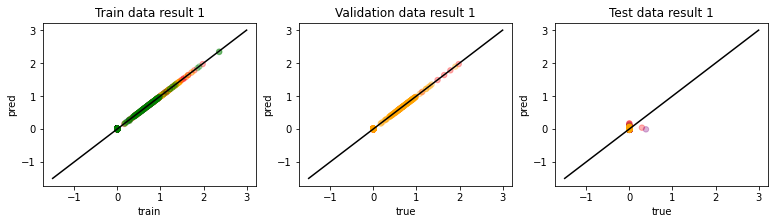

Epoch  49100 Train_loss:  0.0016660547  Validation_loss:  0.0017471777  Test_loss:  0.027884232
Epoch  49200 Train_loss:  0.0016463861  Validation_loss:  0.0017297649  Test_loss:  0.02789008
Epoch  49300 Train_loss:  0.0016172325  Validation_loss:  0.001696798  Test_loss:  0.027900854
Epoch  49400 Train_loss:  0.0016195273  Validation_loss:  0.0017073661  Test_loss:  0.027906993
Epoch  49500 Train_loss:  0.0016331922  Validation_loss:  0.0017297863  Test_loss:  0.027868789
Epoch  49600 Train_loss:  0.0016309347  Validation_loss:  0.0017351602  Test_loss:  0.027866032
Epoch  49700 Train_loss:  0.0016002639  Validation_loss:  0.0016920306  Test_loss:  0.027859548
Epoch  49800 Train_loss:  0.0016662508  Validation_loss:  0.0017871893  Test_loss:  0.02782492
Epoch  49900 Train_loss:  0.001675178  Validation_loss:  0.0017910253  Test_loss:  0.027819773
Epoch  50000 Train_loss:  0.0017018699  Validation_loss:  0.0018254165  Test_loss:  0.027791599


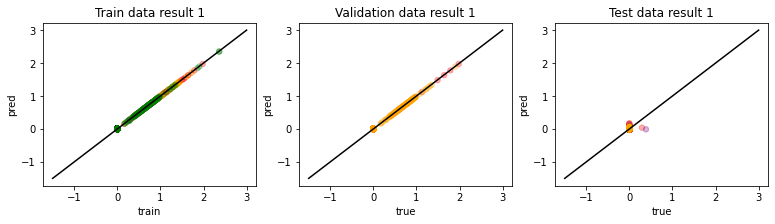

In [43]:
num_epochs = 50001
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)